# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
plt.rcParams.update({
    'font.size': 18,
    'axes.linewidth':2,
    'axes.titlesize': 20,
    'lines.linewidth' : 1.5,
    'lines.markersize' : 10,
    'figure.figsize': (25,10),
    'xtick.labelsize': 15, 
    'ytick.labelsize': 15,
    'font.family': 'Arial',
    'legend.fontsize':14,
    'axes.labelsize':20,
    'axes.grid':True,
})

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Importing Kuramoto dataset

We first import the solution obtained from the Kuramoto differential equation subject to periodic boundary conditions. The spatial domain has length L=200 and discretized with 256 nodes. The time step was 0.25 s with a time domain from t=0 to t=2000 s.

$$ u_t + u_x u + u_{xx} + u_{xxxx}=0 \tag{1}$$ 


$$ u(t=0,x) = cos \frac{\pi x}{20}*(1+sin\frac{\pi x}{20})  \tag{2}$$


The first 100 seconds were truncated in order to view the more chaotic part of the solution

In [5]:
X = np.load('Kuramoto_dataset\Kuramoto_X.npy')
T = np.load('Kuramoto_dataset\Kuramoto_T.npy')
U = np.load('Kuramoto_dataset\Kuramoto_U.npy')

In [6]:
X.shape

(40001, 256)

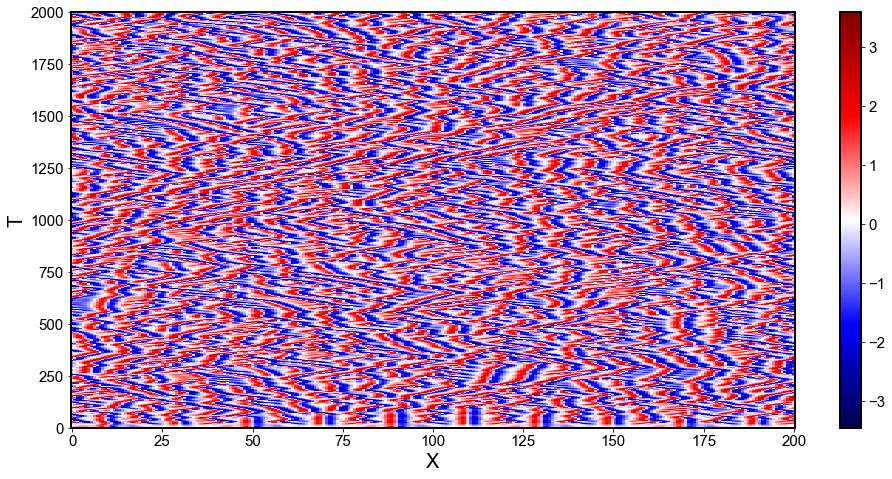

In [7]:
fig, ax = plt.subplots(figsize=(14, 7))

surf = ax.pcolor(X, T, U, cmap=plt.get_cmap("seismic"),shading='auto')

plt.colorbar(surf)
plt.xlabel('X')
plt.ylabel('T')
plt.tight_layout()

In [8]:
# Taking out the first 300 seconds of data to avoid any transient effects

X = X[6000:]
T = T[6000:]
U = U[6000:]

## Creating the training and test set for evaluating PCA

In [9]:
X_train = X[:28000]
T_train = T[:28000]
U_train = U[:28000]

X_test = X[28000:]
T_test = T[28000:]
U_test = U[28000:]

In [10]:
print(U_train.shape)
print(U_test.shape)

(28000, 256)
(6001, 256)


In [11]:
# Normalizing the dataset to be with 0 mean and unit variance

scaler = StandardScaler()

U_scaled_train = scaler.fit_transform(U_train)
U_scaled_test = scaler.transform(U_test)

# Applying dimensionality reduction for the Kuramoto dataset - PCA

In [12]:
from utils import dim_reduction

In [13]:
pca = dim_reduction.pca(U=U_scaled_train,threshold=0.99)
path = './pca_models/pca_Kuramoto'
pca.save_model(path=path)

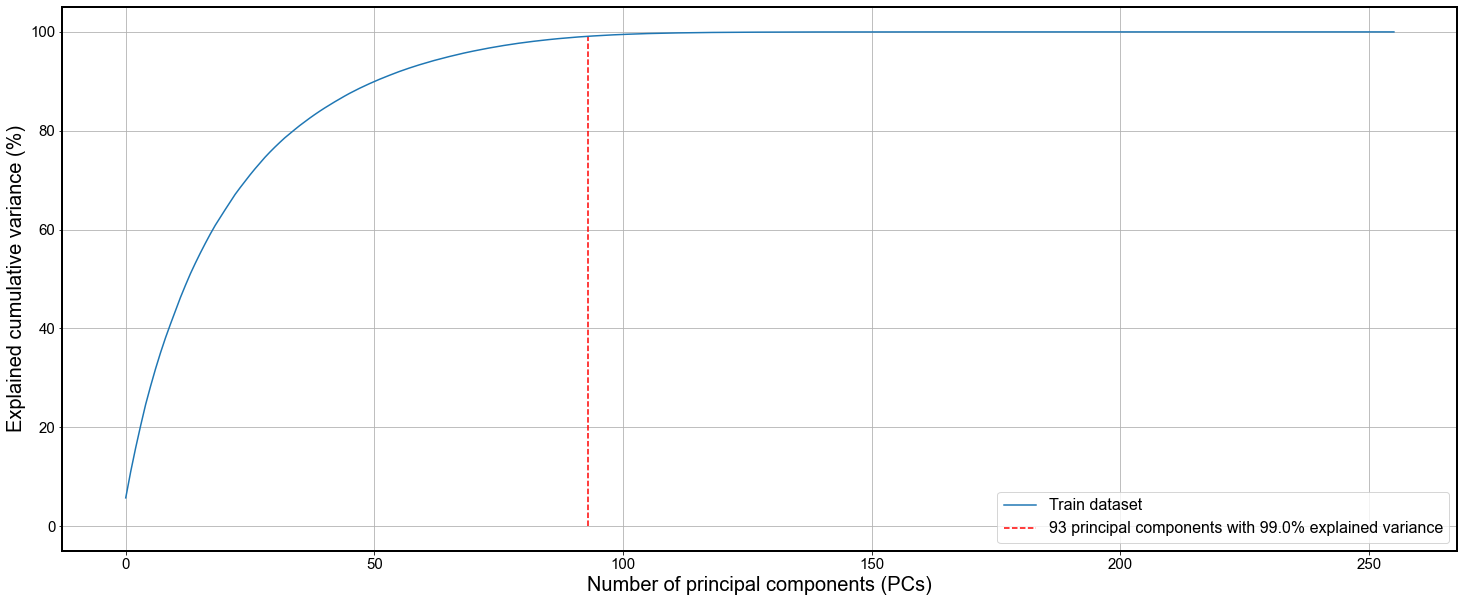

In [14]:
pca.plot_pca()

In [15]:
pca.model_red

PCA(n_components=93)

In [16]:
U_train_pca = pca.model_red.fit_transform(U_scaled_train)
U_test_pca = pca.model_red.transform(U_scaled_test)

print(U_train_pca.shape)
print(U_scaled_train.shape)

(28000, 93)
(28000, 256)


In [17]:
U_train_reduced = pca.model_red.inverse_transform(U_train_pca)
U_test_reduced = pca.model_red.inverse_transform(U_test_pca)

print(U_train_reduced.shape)
print(U_scaled_train.shape)

U_train_reduced_inverse = scaler.inverse_transform(U_train_reduced)  # Apply inverse transform to obtain dataset in same scale as the original data
U_test_reduced_inverse = scaler.inverse_transform(U_test_reduced)

(28000, 256)
(28000, 256)


Mean absolute error (MAE) for training set: 0.10008716910144304


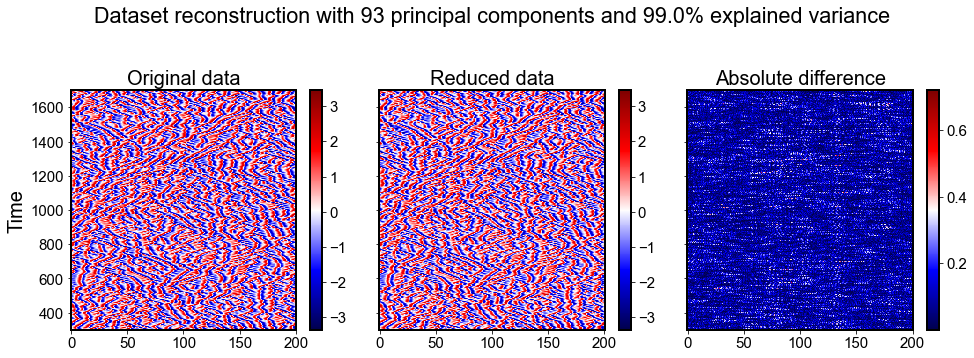

In [18]:
fig, ax, diff = pca.plot_compare(X=X_train,
                 T=T_train,
                 U = U_train,
                 U_reduced = U_train_reduced_inverse)

print('Mean absolute error (MAE) for training set: {}'.format(diff.mean()))

Mean absolute error (MAE) for test set: 0.18087414222057047


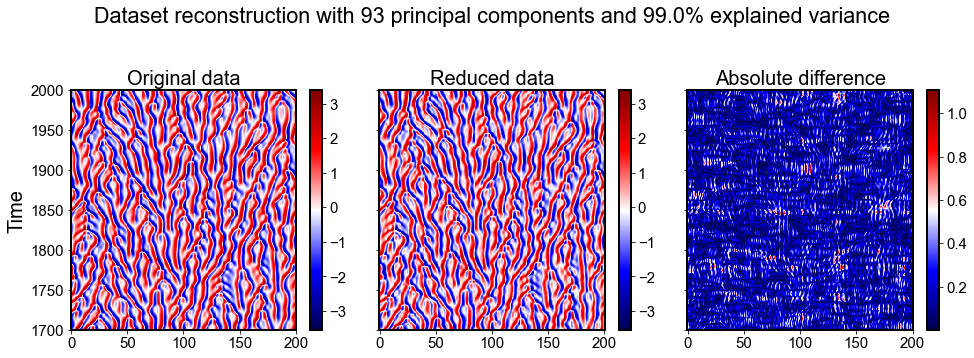

In [19]:
fig, ax, diff = pca.plot_compare(X=X_test,
                 T=T_test,
                 U = U_test,
                 U_reduced = U_test_reduced_inverse)

print('Mean absolute error (MAE) for test set: {}'.format(diff.mean()))

Using Standardcaler: 

Training set error: 0.100

Test ser error: 0.1808

From the above plot, we consider the precision to be sufficient for this application.

## Final ROM from Kuramoto equation

In [20]:
scaler2 = StandardScaler()
U_scaled2 = scaler2.fit_transform(U)

U_pca = pca.model_red.fit_transform(U_scaled2)
U_pca.shape

(34001, 93)

In [21]:
pca.model_red

PCA(n_components=93)

In [22]:
df = pd.DataFrame(U_pca)
df

0         1         2         3         4         5         6   \
0      6.677109 -5.978096  2.577128  3.304686 -3.736464 -0.074265 -3.493094   
1      6.682495 -5.987902  2.547367  3.372001 -3.782339 -0.075114 -3.480440   
2      6.687168 -5.997976  2.518633  3.438409 -3.826708 -0.076127 -3.467654   
3      6.691120 -6.008337  2.490907  3.503894 -3.869574 -0.077293 -3.454737   
4      6.694344 -6.019005  2.464172  3.568447 -3.910938 -0.078604 -3.441687   
...         ...       ...       ...       ...       ...       ...       ...   
33996  2.855421 -0.621361  1.351222 -1.553371 -2.786034 -2.911797  1.980202   
33997  2.797995 -0.619598  1.381212 -1.590193 -2.786908 -2.961349  1.987868   
33998  2.740946 -0.617536  1.412142 -1.626961 -2.787288 -3.010079  1.996612   
33999  2.684333 -0.615140  1.443966 -1.663629 -2.787196 -3.057906  2.006431   
34000  2.628211 -0.612375  1.476639 -1.700145 -2.786657 -3.104758  2.017319   

             7         8         9   ...        83        84        85  \
0      1.664380  3.546049 -1.973562  ...  0.480751 -0.224632 -0.583113   
1      1.681142  3.513415 -1.990802  ...  0.487979 -0.243688 -0.581060   
2      1.697629  3.479227 -2.006757  ...  0.495019 -0.262244 -0.578148   
3      1.713832  3.443537 -2.021472  ...  0.501841 -0.280287 -0.574378   
4      1.729745  3.406396 -2.034995  ...  0.508417 -0.297804 -0.569758   
...         ...       ...       ...  ...       ...       ...       ...   
33996  7.583428 -1.217830  1.964478  ...  0.517944  0.399291  0.959149   
33997  7.581834 -1.236074  2.007303  ...  0.520444  0.385076  0.952896   
33998  7.580036 -1.253666  2.048377  ...  0.522427  0.370590  0.945740   
33999  7.578022 -1.270522  2.087600  ...  0.523891  0.355844  0.937709   
34000  7.575780 -1.286558  2.124873  ...  0.524833  0.340851  0.928836   

             86        87        88        89        90        91        92  
0     -0.230747  1.011664  0.171511  0.488544 -1.094601  0.923754  0.605552  
1     -0.230065  1.009364  0.187786  0.486173 -1.089255  0.916660  0.595319  
2     -0.229318  1.006804  0.204333  0.483689 -1.084188  0.909132  0.585037  
3     -0.228486  1.003994  0.221109  0.481113 -1.079434  0.901183  0.574697  
4     -0.227551  1.000943  0.238072  0.478469 -1.075023  0.892828  0.564288  
...         ...       ...       ...       ...       ...       ...       ...  
33996 -0.803488  0.315453 -1.300203 -0.655125 -0.867227 -0.414508  0.175312  
33997 -0.808952  0.316958 -1.321028 -0.658707 -0.878161 -0.414625  0.167497  
33998 -0.814682  0.318228 -1.342182 -0.662221 -0.888409 -0.414387  0.159445  
33999 -0.820672  0.319265 -1.363592 -0.665690 -0.897944 -0.413833  0.151175  
34000 -0.826917  0.320069 -1.385183 -0.669138 -0.906739 -0.413005  0.142710  

[34001 rows x 93 columns]

# Plotting a sample of the reduced time series

In [23]:
from utils.plotting import plot_samples, plot_autocorrelation, dual_heat_map

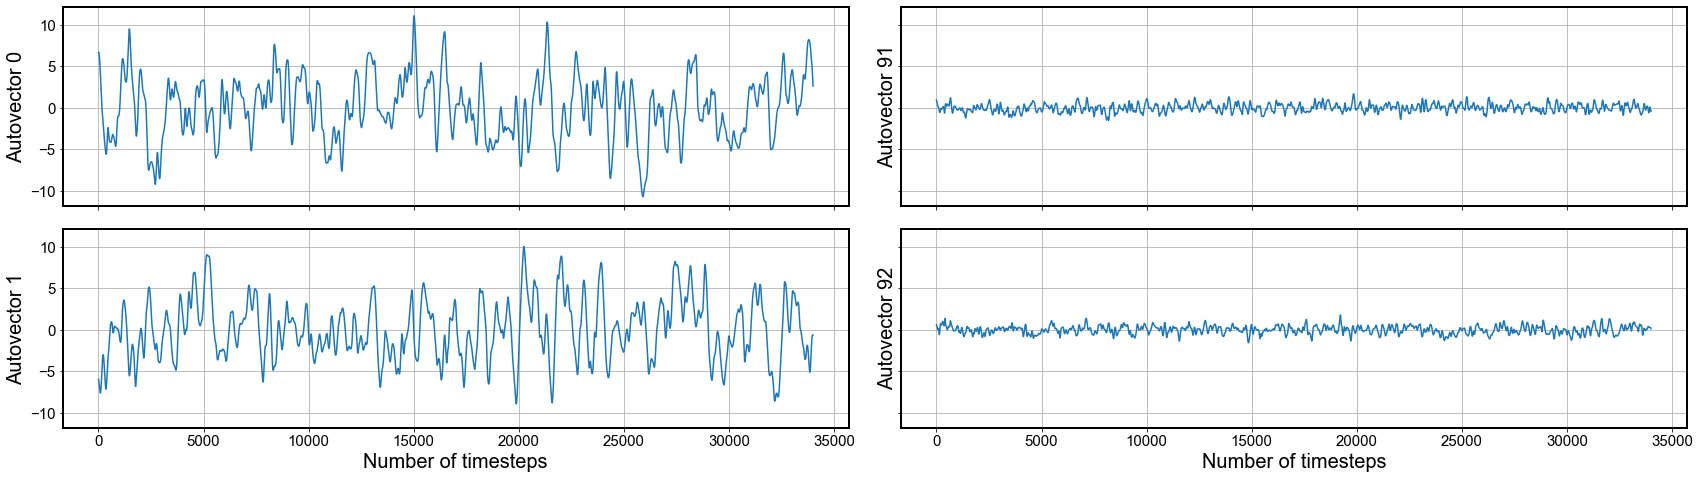

In [24]:
plot_samples(df)

The time series seem to be random values around 0. Is there some pattern in this data? If so, the selection of forecasting model would be easier.

We can see that the amplitude of the first few time series (which corresponds to the most important eigenvectors) have larger amplitude and lower frequency compared last eigenvectors (lower amplitude/energy and higher frequency).

# Statistical analysis of time series 

Statistical analysis has the objective of better understanding the behavior of our time series in order to better define our model

## Dickey-Fuller Test - visualize stationarity

This is the statistical test that we run to determine if a time series is stationary or not. Without going into the technicalities of the Dickey-Fuller test, it tests the null hypothesis that a unit root is present.

- If it is, then p > 0.05, and the process is not stationary.
- Otherwise, p < 0.05, the null hypothesis is rejected, and the process is considered to be stationary.

When the test statistic is lower than the critical value shown, you reject the null hypothesis and infer that the time series is stationary.

In [25]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

In [26]:
# Augmented Dickey-Fuller Test

def ADF_test(timeseries, dataDesc):
    print(' > Is {} stationary?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='t-stat')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Lags used = {:.3f}'.format(dftest[2]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

for i in range(5):
    ADF_test(df[df.columns[i]],'Autovector ' + str(i))
    print('')

 > Is Autovector 0 stationary?
Test statistic = -0.783
P-value = 0.824
Lags used = 8.000
Critical values :
	1%: -3.430542392147882 - The data is not stationary with 99% confidence
	5%: -2.8616250324956867 - The data is not stationary with 95% confidence
	10%: -2.5668152601387706 - The data is not stationary with 90% confidence

 > Is Autovector 1 stationary?
Test statistic = -0.365
P-value = 0.916
Lags used = 8.000
Critical values :
	1%: -3.430542392147882 - The data is not stationary with 99% confidence
	5%: -2.8616250324956867 - The data is not stationary with 95% confidence
	10%: -2.5668152601387706 - The data is not stationary with 90% confidence

 > Is Autovector 2 stationary?
Test statistic = -0.162
P-value = 0.943
Lags used = 8.000
Critical values :
	1%: -3.430542392147882 - The data is not stationary with 99% confidence
	5%: -2.8616250324956867 - The data is not stationary with 95% confidence
	10%: -2.5668152601387706 - The data is not stationary with 90% confidence

 > Is Auto

In [27]:
# Visualizing stationarity for the least important eigenvectors
for i in range(5):
    ADF_test(df[df.columns[i+85]],'Autovector' + str(i+85))
    print('')

 > Is Autovector85 stationary?
Test statistic = -1.371
P-value = 0.596
Lags used = 8.000
Critical values :
	1%: -3.430542392147882 - The data is not stationary with 99% confidence
	5%: -2.8616250324956867 - The data is not stationary with 95% confidence
	10%: -2.5668152601387706 - The data is not stationary with 90% confidence

 > Is Autovector86 stationary?
Test statistic = -0.028
P-value = 0.956
Lags used = 9.000
Critical values :
	1%: -3.430542397808401 - The data is not stationary with 99% confidence
	5%: -2.8616250349974126 - The data is not stationary with 95% confidence
	10%: -2.566815261470375 - The data is not stationary with 90% confidence

 > Is Autovector87 stationary?
Test statistic = -0.128
P-value = 0.947
Lags used = 9.000
Critical values :
	1%: -3.430542397808401 - The data is not stationary with 99% confidence
	5%: -2.8616250349974126 - The data is not stationary with 95% confidence
	10%: -2.566815261470375 - The data is not stationary with 90% confidence

 > Is Autove

We can see that our dataset contains mostly non-stationary signals. If traditional time series forecasting algorithms are to be used, they must be the ones that deal with non stationary signals like ARIMA (Autoregressive Integrated Moving Average) or SARIMA (Seasonal Autoregressive Integrated Moving Average). 

Machine learning algorithms should also be able to deal with non stationary signals without having to worry about this type of data preprocessing.

## Detecting the presence of white noise

A time series can be summarized by the following formula:

y(t) = signal(t) + noise(t)

It is expected that a time series signal contains white noise. Therefore, it is an important concept for time series analysis to confirm if the signal has this for two main reasons:

- **Predictability:** if the time series is white noise, then it is, by definition, random. You cannot reasonably model it and make predictions
- **Model diagnostics:** The errors of a model should, ideally, be white noise. This means that all signal information in the time series has been harnessed by the model in order to make the predictions. If the model output is not white noise, it is an indication that further improvements can be made. 

The time series in not white noise if any of the following conditions are true:

- Time series have non-zero mean;
- The variance change over time;
- There exists correlation with lag values.

In [28]:
df.mean()

0    -4.474720e-16
1    -7.578780e-16
2    -6.032774e-16
3     2.082149e-15
4    -1.962150e-15
          ...     
88    1.719293e-16
89    4.679452e-16
90    4.570393e-16
91    2.499659e-16
92   -5.117365e-16
Length: 93, dtype: float64

The time series appear to all have zero mean. The standard deviation case is harder to do so lets avoid this for now and look at the lag values and visualize autocorrelation

In [29]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm

For random data, autocorrelations should be near zero for all lags. Analysts also refer to this condition as white noise. Non-random data have at least one significant lag. When the data are not random, it’s a good indication that you need to use a time series analysis or incorporate lags into a regression analysis to model the data appropriately. 

Looking again into stationarity, our signal must: 

- Not have a trend (mean=0);
- Have constant variance; 
- Have a constant autocorrelation pattern (below the confidence interval);
- Have no seasonal pattern. 

The autocorrelation function (ACF) declines to near zero rapidly for a stationary time series. For a non-stationary time series, the ACF drops slowly (our case takes 300 lags). There is also no seasonal components since there are no repetitive peaks in defined multiples. 

The confidence interval of 95% is represented by the shaded cone. Values outside the cone suggest very likely correlation and not a statistical fluke. Looks like only first lags have autocorrelation. 

Source: https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/ 

Let us now take a closer look at the partial autocorrelation (PACF). Instead of finding correlations of present values with lags like ACF, PACF finds correlation of the residuals with the next lag. It is a function that measures the incremental benefit of adding another lag. So if through the PACF function we discover that there is hidden information in the residual that can be modeled by the next lag, we might get a good correlation, and we will keep that next lag as a feature while modeling.

As mentioned before, an autoregression is a model based on the assumption that present values of a time series can be obtained using previous values of the same time series: the present value is a
weighted average of its past values. In order to avoid multicollinear features for time series models, it is necessary to find optimum features or order of the autoregression process using the PACF
plot, as it removes variations explained by earlier lags, so we get only the relevant features.

100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


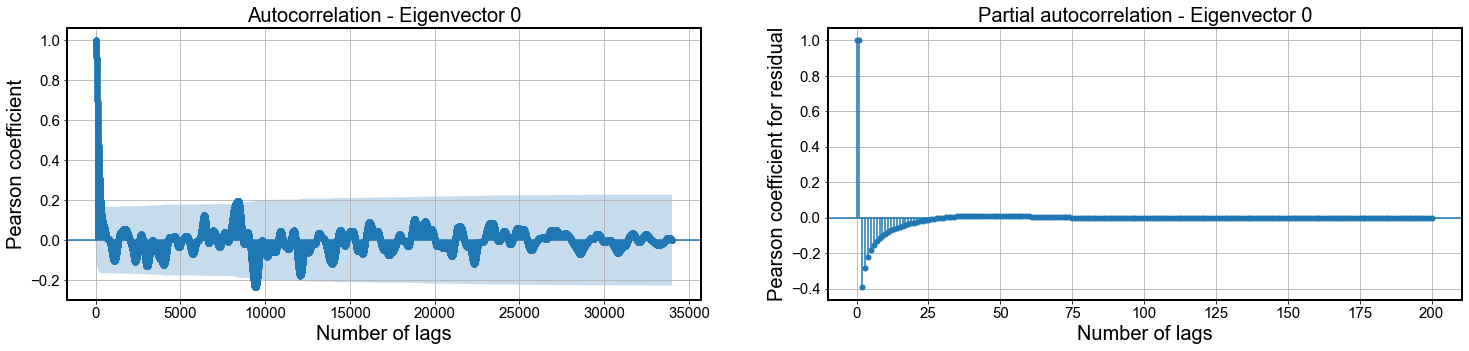

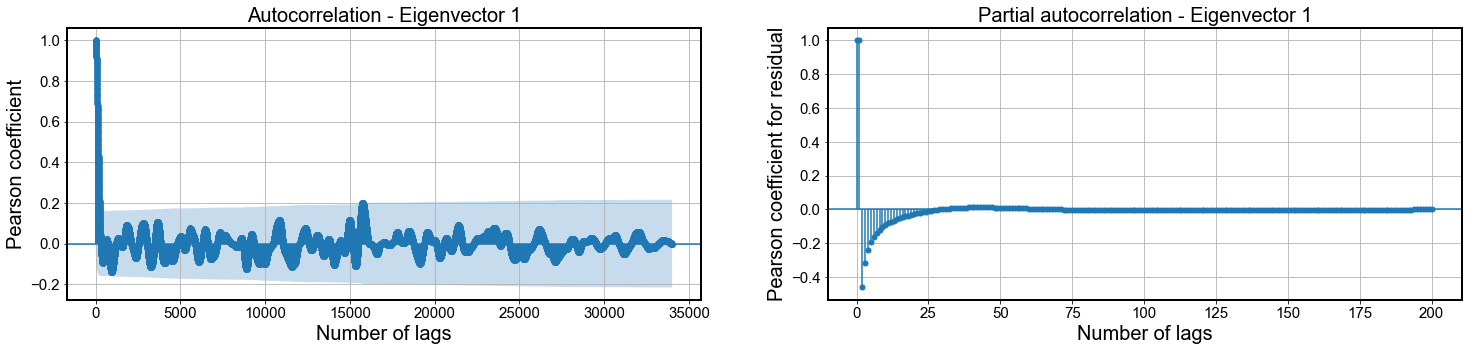

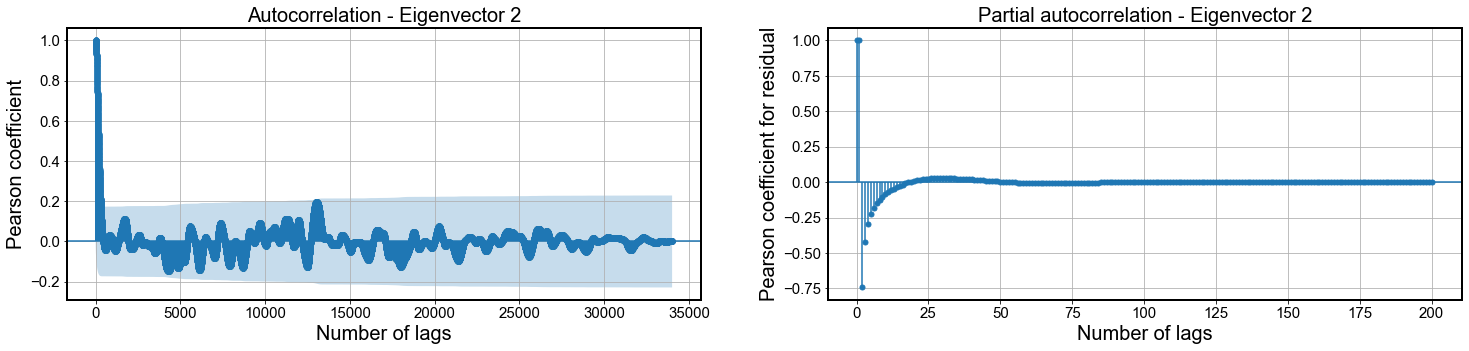

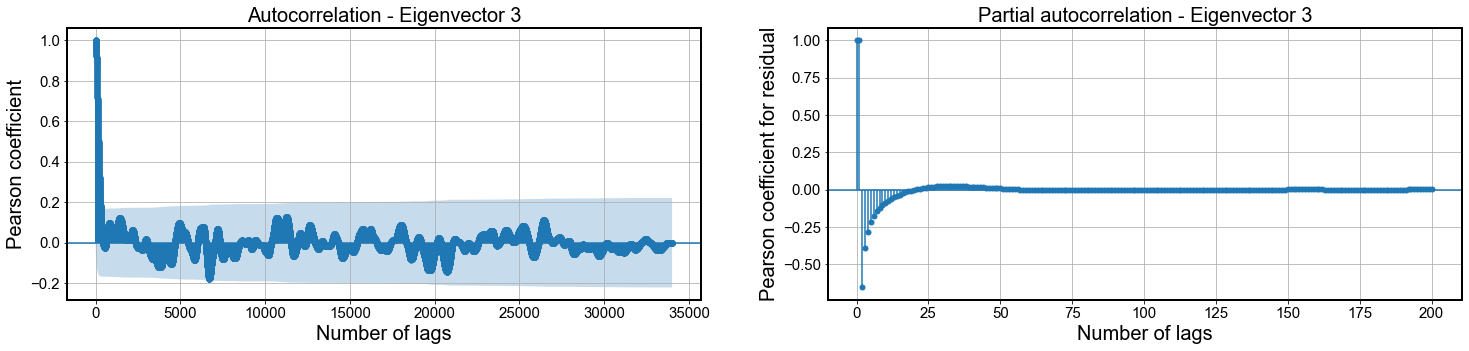

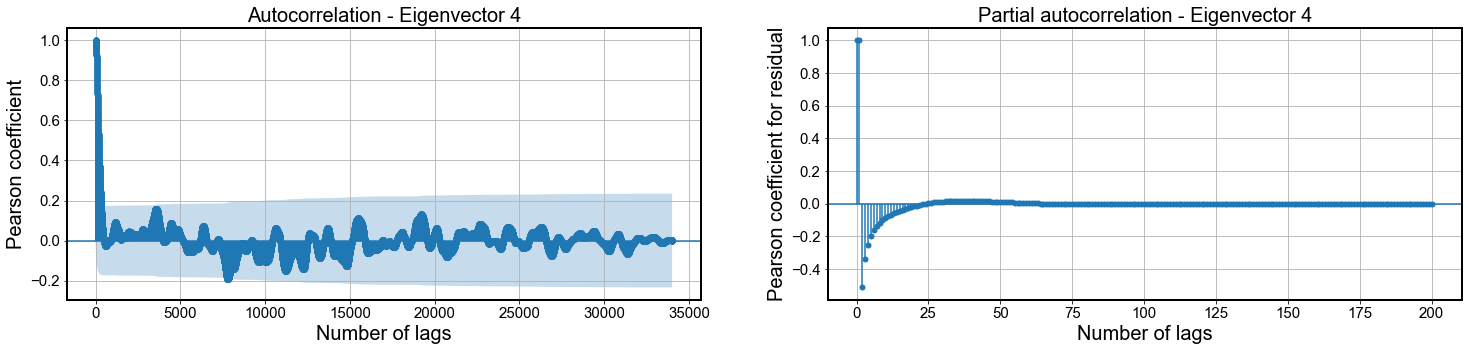

In [30]:
for i in tqdm(range(5)):
    plot_autocorrelation(df,i)

100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


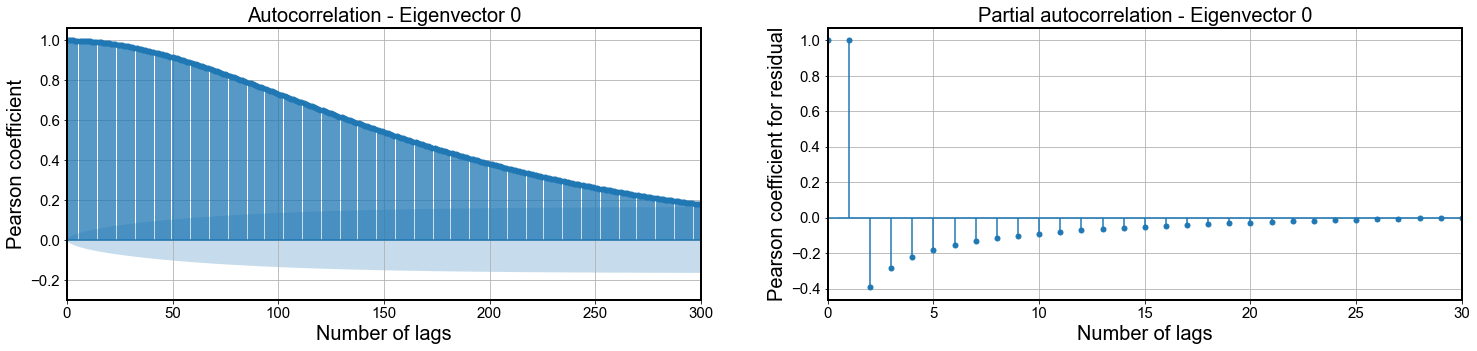

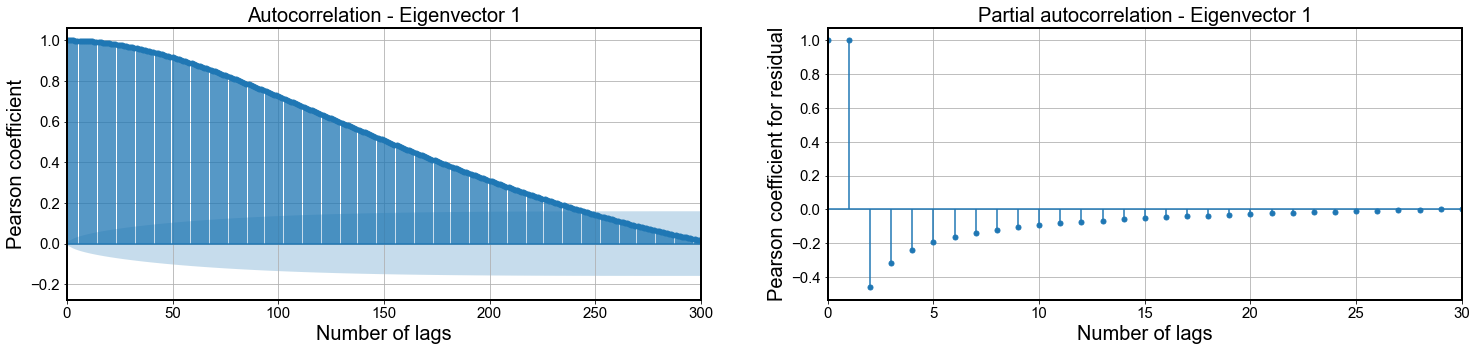

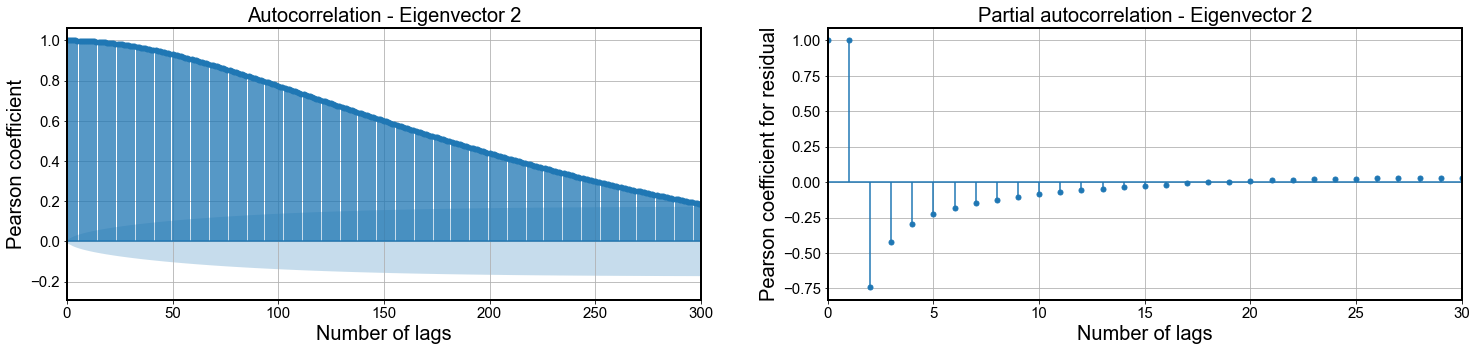

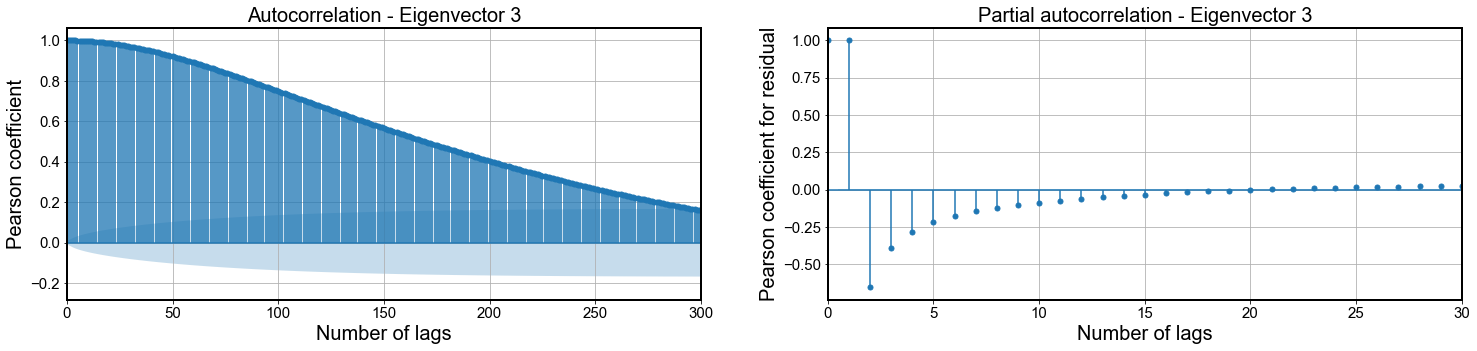

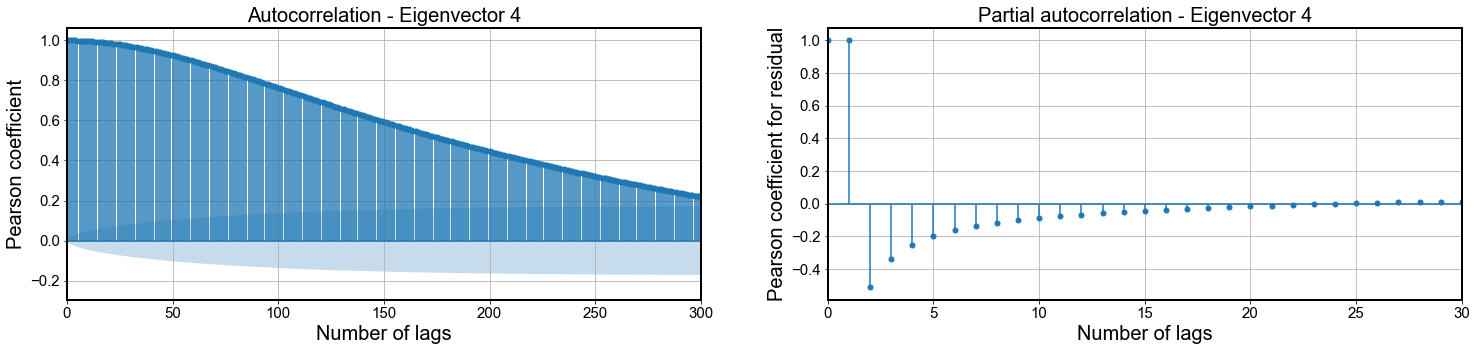

In [31]:
for i in tqdm(range(5)):
    plot_autocorrelation(df,i,zoom=True)

100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


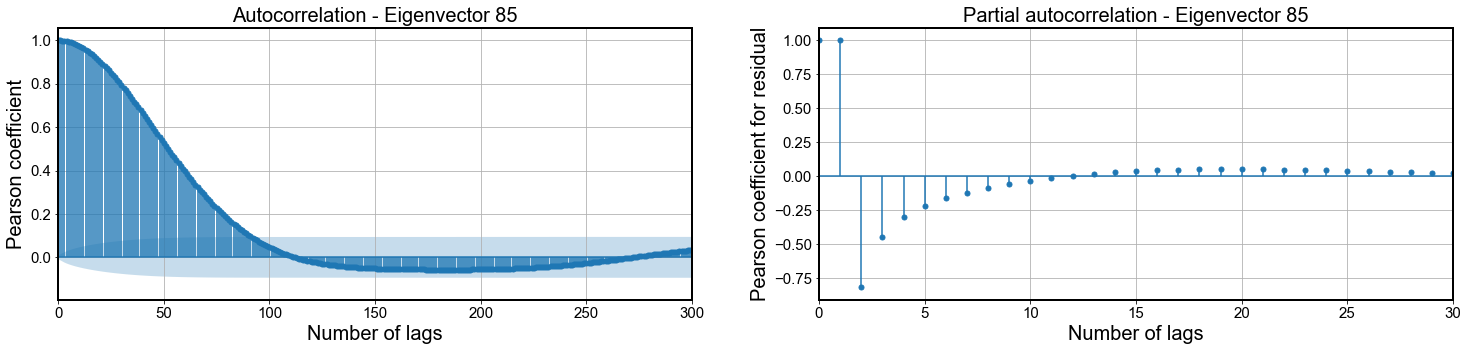

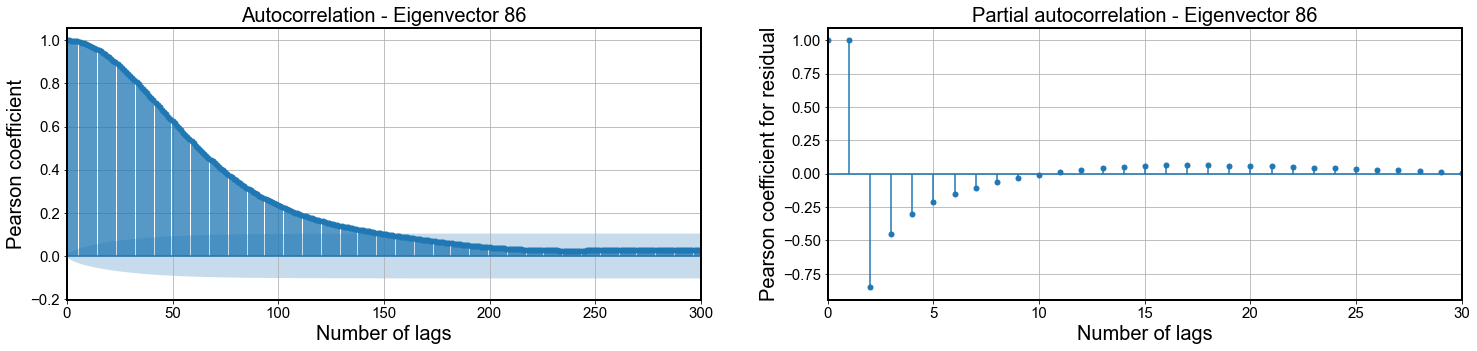

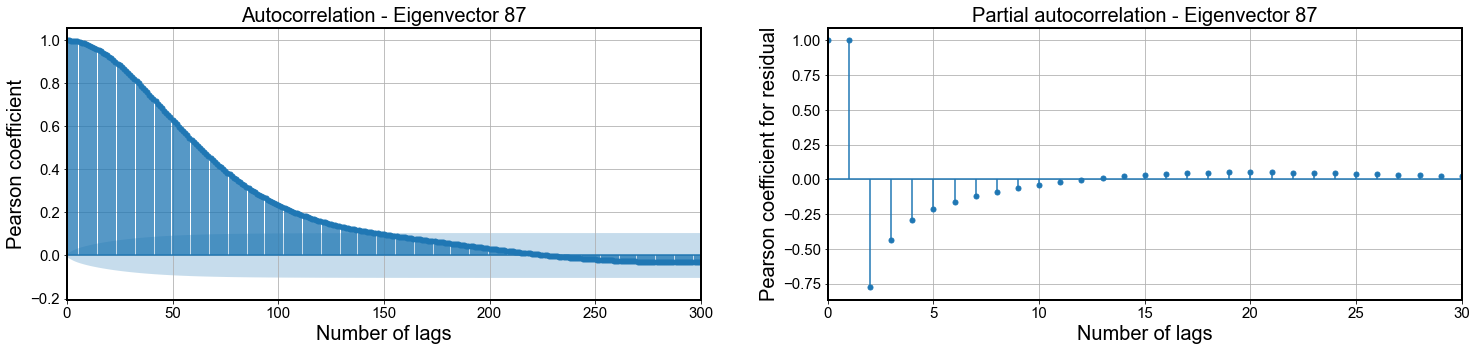

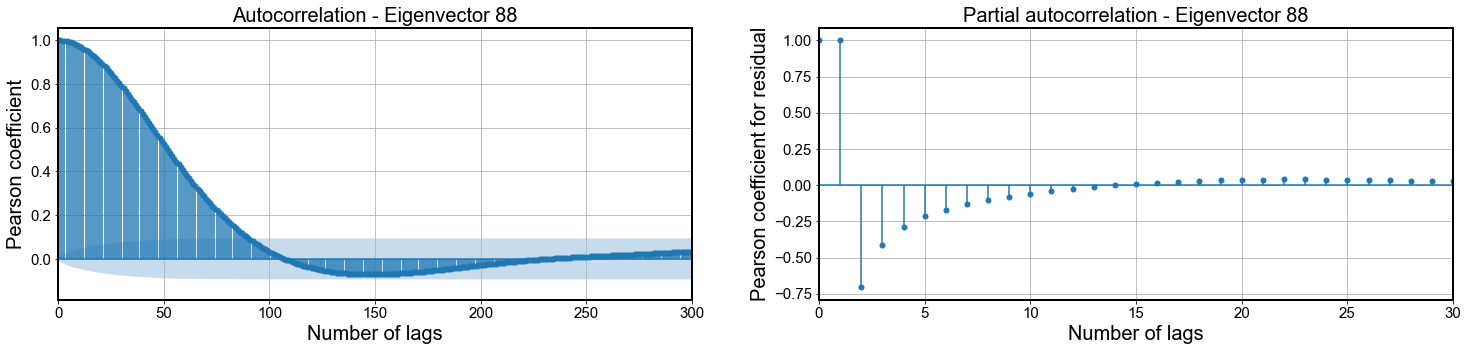

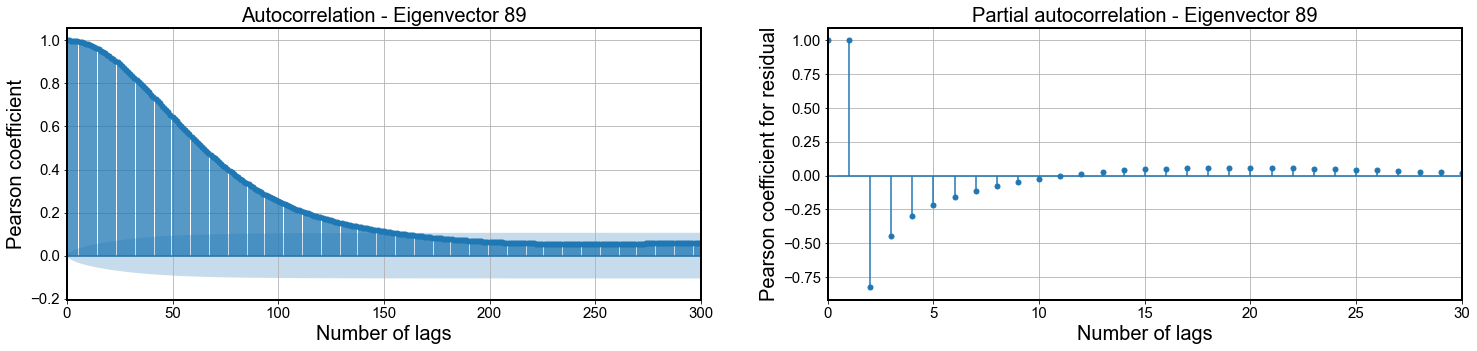

In [32]:
for i in tqdm(range(5)):
    plot_autocorrelation(df,i+85,zoom=True) # Last eigenvectors

From the partial autocorrelation plots, the most extreme lag that can be used a predictor would a lag between 1 and 5 based on the Pearson coefficient. 

Also, the cone of 95% is very small in the PACF plot. This leads us to believe that many lag components have some correlation, even though it is miniscule. Therefore, can be ignored.

Source: 
- https://www.linkedin.com/pulse/how-use-machine-learning-time-series-forecasting-vegard-flovik-phd-1f/
- https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424
- Book: Machine learning for time series forecasting with Python - Francesca Lazzeri (for explaining PACF and ACF)
- https://stats.stackexchange.com/questions/226468/how-many-lags-should-i-include-in-time-series-prediction 

# Creating the dataset for typical ML models

We must frame our time series forecasting problem as a supervised learning problem. Given an input dataset **X** and an output variable **y**, we will try to find a mapping function from the input to the output. This involves using past and present values to obtain future values.

To do so, our dataset **X** must be the data at present and previous time step while **y** must be the data at the next time step. The order between observations must be preserved due to the observed dependency with past values. 

The definition of "next time step" must also be studied. Should we forecast one step into the future? Maybe the model is still accurate for 41 time steps into the future? Who nows? We must test this to see when model accuracy starts to drop.

Note that we are working with a **multivariate time series**, meaning that two or more variables (eigenvectors in this case) are observed at each time. In this specific case, we are working with PCA components. Due to their property of orthogonality, each of the 93 eigenvector time series are linearly independent (uncorrelated) with one another. This is a necessary condition for independence, but not a sufficient condition since higher order dependence may exist. We assume that the orthogonality is sufficient to state that the time series are independent, especially since we are dealing with a chaotic system


## Now actually creating the dataset

In [33]:
def create_dataset(df,series_column_name,nlags=5,HORIZON=50):
    df_series = pd.DataFrame(df[series_column_name]) # Selecting one time series from the dataframe
    df_series.columns=['t']
    
    for k in range(1,nlags): # Create input dataset with lagged features
        label = 'Lag_' + str(k)
        df_series[label] = df_series['t'].shift(k) # lag column of value k
    
    
    df_series['Forecast_' + str(HORIZON-1)] = df_series['t'].shift(-HORIZON)
    
    df_series.dropna(inplace=True)
    return df_series

NLAGS = 4
HORIZON=80
EIGENVECTOR_NUMBER = 1
dataframe = create_dataset(df,EIGENVECTOR_NUMBER,nlags=NLAGS,HORIZON=HORIZON)
dataframe

t     Lag_1     Lag_2     Lag_3  Forecast_79
3     -6.008337 -5.997976 -5.987902 -5.978096    -7.560852
4     -6.019005 -6.008337 -5.997976 -5.987902    -7.571808
5     -6.029993 -6.019005 -6.008337 -5.997976    -7.581688
6     -6.041317 -6.029993 -6.019005 -6.008337    -7.590448
7     -6.052989 -6.041317 -6.029993 -6.019005    -7.598050
...         ...       ...       ...       ...          ...
33916 -2.442762 -2.503496 -2.564502 -2.625720    -0.621361
33917 -2.382364 -2.442762 -2.503496 -2.564502    -0.619598
33918 -2.322366 -2.382364 -2.442762 -2.503496    -0.617536
33919 -2.262834 -2.322366 -2.382364 -2.442762    -0.615140
33920 -2.203834 -2.262834 -2.322366 -2.382364    -0.612375

[33918 rows x 5 columns]

In [34]:
dataframe_train = dataframe[:28000]
dataframe_test = dataframe[28000:]
print('Training dataframe shape: ', dataframe_train.shape)
print('Test dataframe shape: ', dataframe_test.shape) 

Training dataframe shape:  (28000, 5)
Test dataframe shape:  (5918, 5)


In [35]:
dataframe_train

t     Lag_1     Lag_2     Lag_3  Forecast_79
3     -6.008337 -5.997976 -5.987902 -5.978096    -7.560852
4     -6.019005 -6.008337 -5.997976 -5.987902    -7.571808
5     -6.029993 -6.019005 -6.008337 -5.997976    -7.581688
6     -6.041317 -6.029993 -6.019005 -6.008337    -7.590448
7     -6.052989 -6.041317 -6.029993 -6.019005    -7.598050
...         ...       ...       ...       ...          ...
27998  3.366329  3.359655  3.353703  3.348473     5.520527
27999  3.373725  3.366329  3.359655  3.353703     5.554051
28000  3.381843  3.373725  3.366329  3.359655     5.587441
28001  3.390681  3.381843  3.373725  3.366329     5.620695
28002  3.400239  3.390681  3.381843  3.373725     5.653810

[28000 rows x 5 columns]

In [36]:
dataframe_test

t     Lag_1     Lag_2     Lag_3  Forecast_79
28003  3.410513  3.400239  3.390681  3.381843     5.686784
28004  3.421502  3.410513  3.400239  3.390681     5.719619
28005  3.433201  3.421502  3.410513  3.400239     5.752312
28006  3.445608  3.433201  3.421502  3.410513     5.784866
28007  3.458718  3.445608  3.433201  3.421502     5.817281
...         ...       ...       ...       ...          ...
33916 -2.442762 -2.503496 -2.564502 -2.625720    -0.621361
33917 -2.382364 -2.442762 -2.503496 -2.564502    -0.619598
33918 -2.322366 -2.382364 -2.442762 -2.503496    -0.617536
33919 -2.262834 -2.322366 -2.382364 -2.442762    -0.615140
33920 -2.203834 -2.262834 -2.322366 -2.382364    -0.612375

[5918 rows x 5 columns]

Illustrating the forecasting problem

Text(0.5, 0, 'Number of time steps')

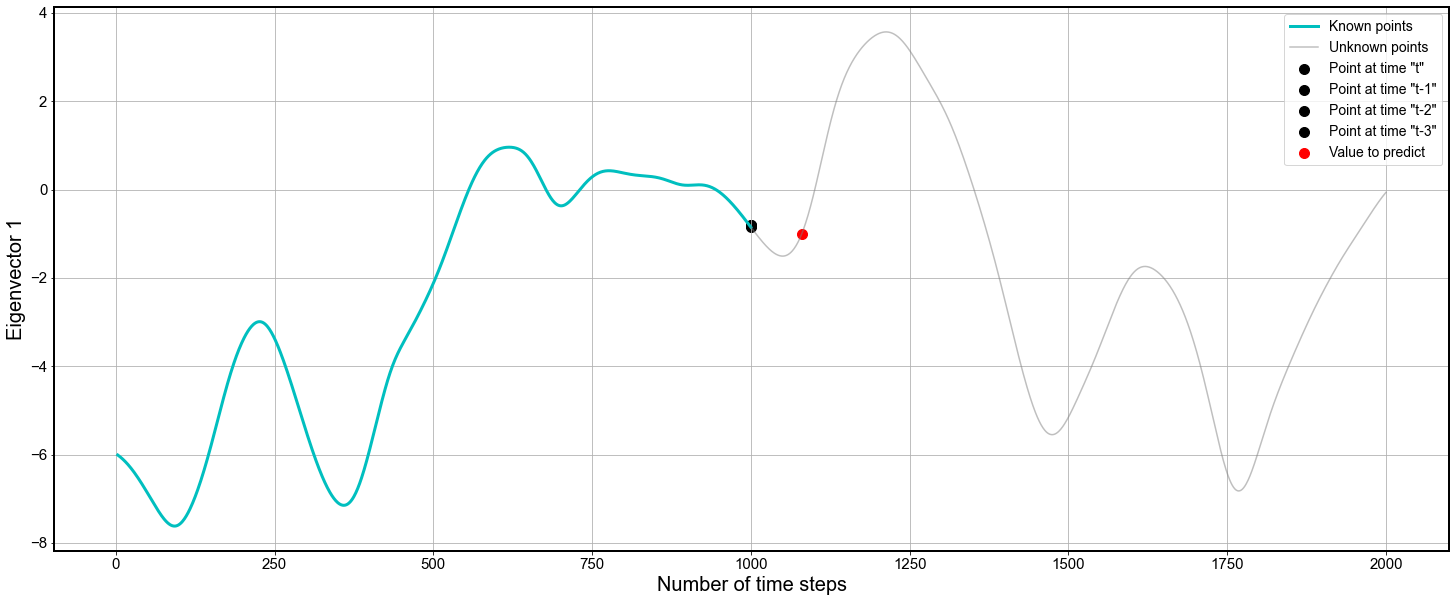

In [37]:
known = dataframe_train['t'].loc[0:1000] # First 1000 values for time series 't' - eigenvector 0 
unknown = dataframe_train['t'].loc[1000:2000] # Next 2000 values for time series 't' - eigenvector 0 
to_predict = dataframe_train['Forecast_79'].loc[1000]

feat1 = dataframe_train['t'].loc[1000]
feat2 = dataframe_train['Lag_1'].loc[1000]  
feat3 = dataframe_train['Lag_2'].loc[1000]
feat4 = dataframe_train['Lag_3'].loc[1000]

fig, ax = plt.subplots()


plt.scatter(1000,feat1, c='k', marker='o',label = 'Point at time "t"')
plt.scatter(1000,feat2, c='k', marker='o',label = 'Point at time "t-1"')
plt.scatter(1000,feat3, c='k', marker='o',label = 'Point at time "t-2"')
plt.scatter(1000,feat4, c='k', marker='o',label = 'Point at time "t-3"')
plt.scatter(1000+HORIZON,to_predict, c='r', marker='o',label = 'Value to predict')


known.plot(ax=ax, c='c', label = 'Known points',linewidth=3)
unknown.plot(ax=ax, c='grey', alpha=0.5,label = 'Unknown points')


ax.legend()
ax.set_ylabel('Eigenvector {}'.format(EIGENVECTOR_NUMBER))
ax.set_xlabel('Number of time steps')

Note how the lagged points are all bunched together. We can also say that using the present and 3 lagged values is the same as using a time window of size 4.

# Feature extraction

In [38]:
# from autofeat import AutoFeatRegressor, FeatureSelector
# from sklearn.model_selection import train_test_split

# X2 = dataframe.drop(dataframe.columns[-1],axis=1)
# y2= dataframe[dataframe.columns[-1]]
# X2

In [39]:
# X_train, X_test, y_train, y_test = train_test_split(X2, y2,test_size=0.1,random_state =0,shuffle=False)

# model = AutoFeatRegressor(verbose=1,feateng_steps=3,featsel_runs=7)
# X_train_tr = model.fit_transform(X_train, y_train)
# X_test_tr = model.transform(X_test)

In [40]:
    # print("autofeat new features:", len(model.new_feat_cols_))
    # print("autofeat MSE on training data:", mean_squared_error(y_train, model.predict(X_train_tr)))
    # print("autofeat MSE on test data:", mean_squared_error(y_test, model.predict(X_test_tr)))
    # print("autofeat R^2 on training data:", r2_score(y_train, model.predict(X_train_tr)))
    # print("autofeat R^2 on test data:", r2_score(y_test, model.predict(X_test_tr)))

In [41]:
# dataframe_tr = pd.concat([X_train_tr,X_test_tr],axis=0,ignore_index=True)
# dataframe_tr.index = X2.index
# dataframe_tr

In [42]:
# dataframe_tr2 = pd.concat([dataframe_tr,y2],axis=1)
# dataframe_tr2

In [43]:
# dataframe_train2 = dataframe_tr2[:30000]
# dataframe_test2 = dataframe_tr2[30000:]
# print('Training dataframe shape: ', dataframe_train.shape)
# print('Test dataframe shape: ', dataframe_test.shape) 

Autofeat did not increase model performance (not shown in notebook)

# Training traditional ML algorithms - test 1

PyCaret Regression Module is a supervised machine learning module used for estimating the relationships between a dependent variable (often called the ‘outcome variable’, or ‘target’) and one or more independent variables (often called ‘features’, or ‘predictors’).

In [44]:
from pycaret.regression import *

clf1 = setup(data = dataframe_train,
             test_data = dataframe_test, 
             target = dataframe_train.columns[-1], 
             data_split_shuffle = False,
             use_gpu = True,
             fold_strategy = 'timeseries',
             preprocess = False,
             fold = 5,
             silent=True,
             session_id = 123) # testing for predicting one time series

In [45]:
models() # display models used by pycaret

Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm               Support Vector Regression   
knn                   K Neighbors Regressor   
dt                  Decision Tree Regressor   
rf                  Random Forest Regressor   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                           MLP Regressor   
lightgbm    Light Gradient Boosting Machine   

                                                  Reference  Turbo  
ID                                                                  
lr              sklearn.linear_model._base.LinearRegression   True  
lasso        sklearn.linear_model._coordinate_descent.Lasso   True  
ridge                     sklearn.linear_model._ridge.Ridge   True  
en        sklearn.linear_model._coordinate_descent.Elast...   True  
lar                  sklearn.linear_model._least_angle.Lars   True  
llar            sklearn.linear_model._least_angle.LassoLars   True  
omp       sklearn.linear_model._omp.OrthogonalMatchingPu...   True  
br                sklearn.linear_model._bayes.BayesianRidge   True  
ard               sklearn.linear_model._bayes.ARDRegression  False  
par       sklearn.linear_model._passive_aggressive.Passi...   True  
ransac         sklearn.linear_model._ransac.RANSACRegressor  False  
tr        sklearn.linear_model._theil_sen.TheilSenRegressor  False  
huber            sklearn.linear_model._huber.HuberRegressor   True  
kr                         sklearn.kernel_ridge.KernelRidge  False  
svm                                sklearn.svm._classes.SVR  False  
knn       sklearn.neighbors._regression.KNeighborsRegressor   True  
dt              sklearn.tree._classes.DecisionTreeRegressor   True  
rf           sklearn.ensemble._forest.RandomForestRegressor   True  
et             sklearn.ensemble._forest.ExtraTreesRegressor   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostRegr...   True  
gbr          sklearn.ensemble._gb.GradientBoostingRegressor   True  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
lightgbm                     lightgbm.sklearn.LGBMRegressor   True

### Training the models 

In [46]:
# Training all models from the above list with the exception of three and get the best 3
top = compare_models(sort = 'MAE',
                      exclude=['par','llar','lasso','omp','en','dt','rf','et'],
                      round = 3,
                      n_select = 3) 

In [47]:
prediction_holdout = predict_model(top[0]); # check score against the test set

In [48]:
# Hyperparameter tuning with optuna 
#top_tuned = tune_model(top2, 
#                 n_iter = 500,
#                 search_library='optuna',
#                 optimize = 'MAE',
#                 verbose=False,
#                 choose_better=True
#                 )
#print(top_tuned)

## Blending 

Blending models is a method of ensembling which uses consensus among estimators to generate final predictions. The idea behind blending is to combine different machine learning algorithms and use a majority vote or the average predicted probabilities in case of classification to predict the final outcome.

A voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. Then it averages the individual predictions to form a final prediction.

In [49]:
# train a voting regressor
blender_specific = blend_models(estimator_list = [top[0],top[2]])

## Ensemble

In [50]:
bagged = ensemble_model(top[0],round=3, n_estimators=100)
print(bagged)

BaggingRegressor(base_estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                              alpha_init=None,
                                              compute_score=False, copy_X=True,
                                              fit_intercept=True,
                                              lambda_1=1e-06, lambda_2=1e-06,
                                              lambda_init=None, n_iter=300,
                                              normalize=False, tol=0.001,
                                              verbose=False),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
                 random_state=123, verbose=0, warm_start=False)


In [51]:
boosted_dt = ensemble_model(top[0],round=3, method = 'Boosting', n_estimators=100)

In [52]:
# generate predictions for the entire dataset
predictions = predict_model(top[0], data=dataframe)
predictions['time_step'] = predictions.index - predictions.index.min() + 1
predictions

t     Lag_1     Lag_2     Lag_3  Forecast_79     Label  \
3     -6.008337 -5.997976 -5.987902 -5.978096    -7.560852 -7.064329   
4     -6.019005 -6.008337 -5.997976 -5.987902    -7.571808 -7.044220   
5     -6.029993 -6.019005 -6.008337 -5.997976    -7.581688 -7.047743   
6     -6.041317 -6.029993 -6.019005 -6.008337    -7.590448 -7.049781   
7     -6.052989 -6.041317 -6.029993 -6.019005    -7.598050 -7.050220   
...         ...       ...       ...       ...          ...       ...   
33916 -2.442762 -2.503496 -2.564502 -2.625720    -0.621361 -0.188962   
33917 -2.382364 -2.442762 -2.503496 -2.564502    -0.619598 -0.263732   
33918 -2.322366 -2.382364 -2.442762 -2.503496    -0.617536 -0.377081   
33919 -2.262834 -2.322366 -2.382364 -2.442762    -0.615140 -0.497941   
33920 -2.203834 -2.262834 -2.322366 -2.382364    -0.612375 -0.586875   

       time_step  
3              1  
4              2  
5              3  
6              4  
7              5  
...          ...  
33916      33914  
33917      33915  
33918      33916  
33919      33917  
33920      33918  

[33918 rows x 7 columns]

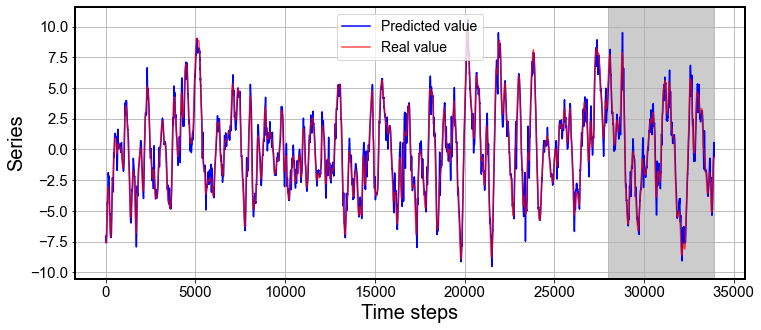

In [53]:
plt.figure(figsize=(12,5))
plt.plot(predictions.time_step,predictions['Label'],color='blue',label='Predicted value')
plt.plot(predictions.time_step,predictions[dataframe.columns[-1]],color='red',alpha=0.7,label='Real value')
plt.xlabel('Time steps')
plt.ylabel('Series')
plt.legend()

# add a vertical rectange for test-set separation
plt.axvspan(xmin=dataframe_test.index[0], xmax = dataframe_test.index[-1],color='grey',alpha=0.4)

(-10.0, 9.0)

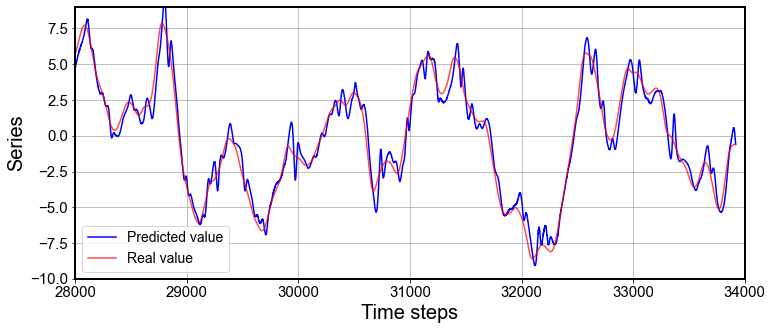

In [54]:
# test set plot

plt.figure(figsize=(12,5))
plt.plot(predictions.time_step,predictions['Label'],color='blue',label='Predicted value')
plt.plot(predictions.time_step,predictions[dataframe.columns[-1]],color='red',alpha=0.7,label='Real value')
plt.xlabel('Time steps')
plt.ylabel('Series')
plt.legend()
plt.xlim([28000,34000])
plt.ylim([-10,9])

The model captures the trend, however, it has a lot of dips and peaks.

# Training all time series

In [55]:
all_results = [] # Save the MAE result for each HORIZON value to determine how far we can forecast
final_model = {}

def train_all_time_series(df,nlags,HORIZON):
    

    
    # Create the 93 time series models
    for i in tqdm(range(len(df.columns))):
        dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON) 

        dataframe_train = dataframe[:28000]
        dataframe_test = dataframe[28000:]    
        
        s = setup(data = dataframe_train,
                     test_data = dataframe_test, 
                     target = dataframe_train.columns[-1], 
                     data_split_shuffle = False,
                     use_gpu = True,
                     fold_strategy = 'timeseries',
                     preprocess = False,
                     fold = 5,
                     silent=True,
                     session_id = 123,
                     verbose=False) # testing for predicting one time series
        
    # Teste and compare different ML models
        best_model = compare_models(sort = 'MAE',
                                    exclude=['lar','ada','llar','rf','par','lightgbm','en','et'],
                                    n_select = 1,
                                    verbose=False) 
    
    # Hyperparameter tuning with optuna 
        best_model_tuned = tune_model(best_model, 
                                      n_iter = 300,
                                      search_library='optuna',
                                      #search_algorithm='tpe',
                                      optimize = 'MAE',
                                      verbose=False,
                                      choose_better=True)
    
    
        # capture the compare result grid and store best model in list
        p = pull().iloc[0:1]
        p['time_series'] = str(i)
        all_results.append(p)
    
        f = finalize_model(best_model_tuned) # finalize model i.e fit on entire dataset including test set
        final_model[i] = f # Attach final model to a dictionary
        save_model(f, model_name='trained_models_Kuramoto/' + str(i), verbose=False) # pickle the trained model into this folder
    
# Source: https://towardsdatascience.com/multiple-time-series-forecasting-with-pycaret-bc0a779a22fe 

In [56]:
NLAGS = NLAGS # From analyzing the PACF plot, this value was chosen. 
HORIZON = HORIZON # Predict `HORIZON` time steps into the future
train_all_time_series(df,nlags=NLAGS,HORIZON=HORIZON)

# https://www.youtube.com/watch?v=_ZQ-lQrK9Rg&ab_channel=CodeEmporium 

100%|██████████| 93/93 [49:07<00:00, 31.69s/it]


In [57]:
# Display the best model selected for each time series.

concat_results = pd.concat(all_results,axis=0)
concat_results.head(10)

MAE     MSE    RMSE      R2   RMSLE    MAPE time_series
0  0.6637  0.6939  0.8330  0.9168  0.2985  1.6784           0
0  0.5217  0.4096  0.6400  0.9626  0.2277  0.8616           1
0  0.5508  0.4936  0.7026  0.9361  0.2712  1.1297           2
0  0.5844  0.5869  0.7661  0.9451  0.2586  1.4179           3
0  0.6049  0.6589  0.8117  0.9212  0.2911  5.6015           4
0  0.5819  0.5183  0.7199  0.9247  0.2679  1.8343           5
0  0.5935  0.5656  0.7520  0.9611  0.2375  1.2539           6
0  0.6211  0.5732  0.7571  0.9482  0.2602  1.5741           7
0  0.6730  0.7125  0.8441  0.9332  0.2702  2.0499           8
0  0.5795  0.5602  0.7485  0.9034  0.2761  1.7794           9

In [58]:
concat_results.tail(10)

MAE     MSE    RMSE      R2   RMSLE     MAPE time_series
0  0.3377  0.1735  0.4165  0.4661  0.2372   4.0001          83
0  0.2828  0.1352  0.3676  0.4215  0.2180   2.6333          84
0  0.3015  0.1491  0.3861  0.2911  0.2237   4.4062          85
0  0.3320  0.1721  0.4149  0.5276  0.2484   2.7360          86
0  0.2684  0.1281  0.3579  0.3948  0.2083   3.9655          87
0  0.3010  0.1449  0.3806  0.3959  0.2323   2.9630          88
0  0.2718  0.1151  0.3393  0.4308  0.2075  40.7248          89
0  0.2948  0.1374  0.3707  0.4858  0.2164   2.4211          90
0  0.3164  0.1556  0.3945  0.4027  0.2264   4.6868          91
0  0.2885  0.1298  0.3603  0.4237  0.2290   2.1659          92

Text(0.5, 1.0, 'Forecasting R^2 for each time series - Horizon=80')

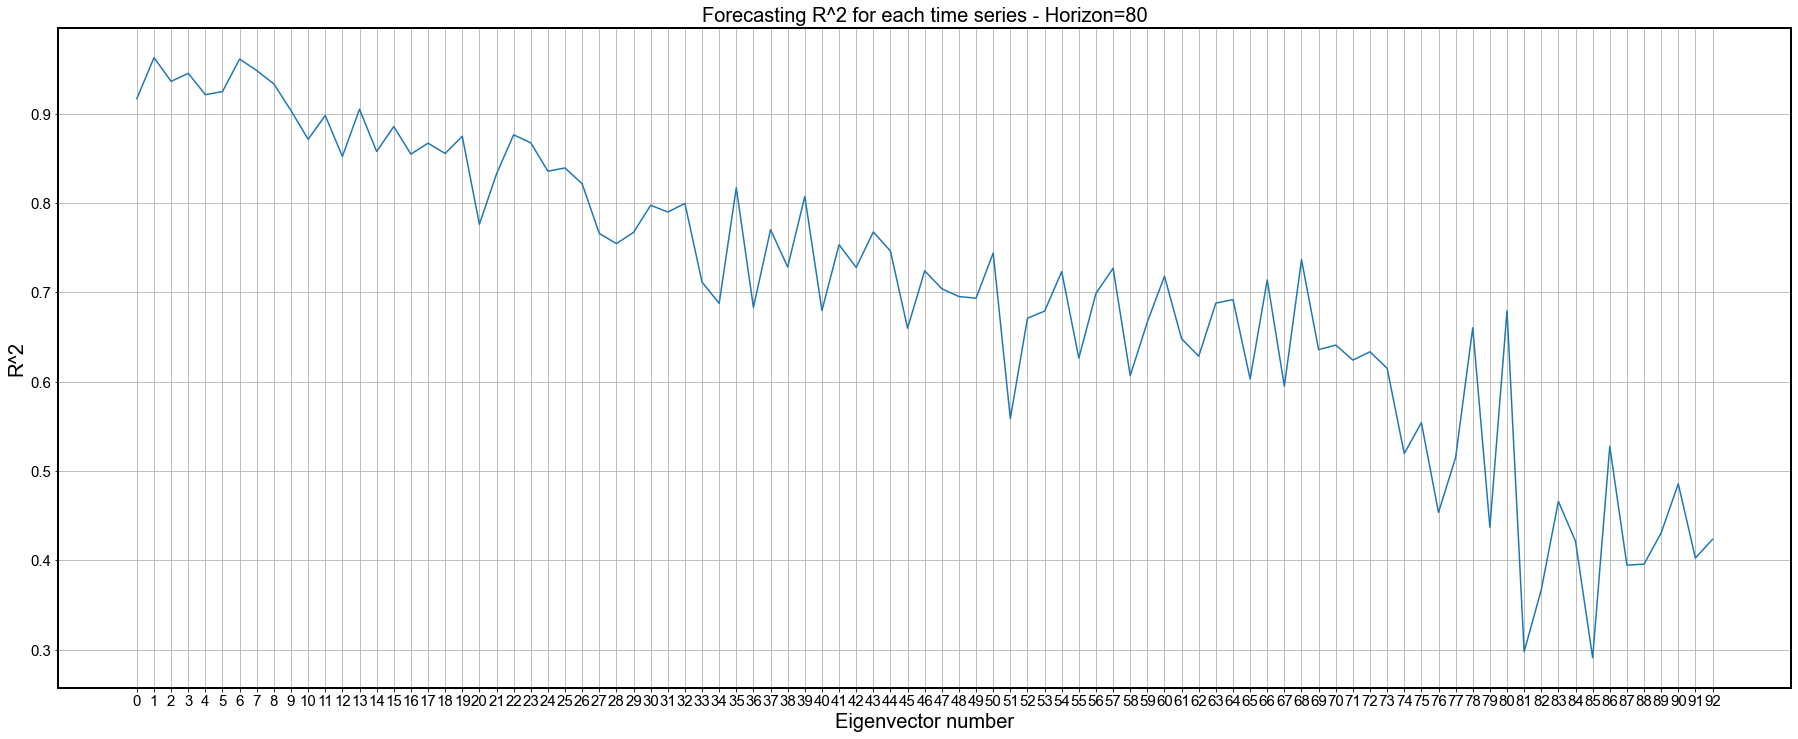

In [59]:
plt.plot(concat_results['time_series'],concat_results['R2'])
plt.tight_layout()
plt.ylabel('R^2')
plt.xlabel('Eigenvector number')
plt.title('Forecasting R^2 for each time series - Horizon=80')

Traditional ML models have an easier time fitting the first eigenvectors compared to the last eigenvectors. This is due to three main reasons:

-  The last eigenvectors have larger frequency compared to the first. The trained models have dificulty in accuratly fitting these sudden changes
-  Looking at the forecasting horizon figure above for eigenvector 1, we see that the horizon window of 80 and the last known point (in blue) can be approximated well by a line. This coincides with the best performing models that Pycaret being linear. Therefore, the first eigenvectors have good results due to the forecasting horizon. 
-  For the last eigenvectors, the faster frequency makes it so that the relationship cannot be approximated so well by linear functions. This is responsible for the worse results. A better overall performance can be obtained by decreasing the forecasting horizon. In this case, the performance of the first eigenvectors will be the same, but the last eigenvectors will be substantially better.

Here is an interesting point to think about. If the last eigenvectors are the least important, should we really care that much about their forecasting being bad?

Let us see if this actually affects the final results

In [60]:
# Now let’s create a loop to load the trained pipelines and use the predict_model function to generate prediction labels.

all_score_df = []

for i in tqdm(range(df.shape[1])):
    l = load_model('trained_models_Kuramoto/' + str(i), verbose=False)
    
    dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON) 
    dataframe_train = dataframe[:28000]
    dataframe_test = dataframe[28000:]        
    
    p = predict_model(l, data=dataframe_test)
    all_score_df.append(p)

concat_df = pd.concat(all_score_df, axis=1)
print(concat_df.shape)
concat_df.head(10)

100%|██████████| 93/93 [01:06<00:00,  1.39it/s]

(5918, 558)


t     Lag_1     Lag_2     Lag_3  Forecast_79     Label  \
28003  3.644159  3.591910  3.539268  3.486250     5.783600  5.615569   
28004  3.695995  3.644159  3.591910  3.539268     5.783122  5.619789   
28005  3.747400  3.695995  3.644159  3.591910     5.782004  5.616640   
28006  3.798354  3.747400  3.695995  3.644159     5.780244  5.638237   
28007  3.848842  3.798354  3.747400  3.695995     5.777841  5.627663   
28008  3.898847  3.848842  3.798354  3.747400     5.774794  5.654501   
28009  3.948351  3.898847  3.848842  3.798354     5.771101  5.636611   
28010  3.997341  3.948351  3.898847  3.848842     5.766760  5.655801   
28011  4.045801  3.997341  3.948351  3.898847     5.761768  5.655916   
28012  4.093717  4.045801  3.997341  3.948351     5.756122  5.668331   

              t     Lag_1     Lag_2     Lag_3  ...     Lag_2     Lag_3  \
28003  3.410513  3.400239  3.390681  3.381843  ...  0.399651  0.394436   
28004  3.421502  3.410513  3.400239  3.390681  ...  0.404466  0.399651   
28005  3.433201  3.421502  3.410513  3.400239  ...  0.408883  0.404466   
28006  3.445608  3.433201  3.421502  3.410513  ...  0.412905  0.408883   
28007  3.458718  3.445608  3.433201  3.421502  ...  0.416534  0.412905   
28008  3.472526  3.458718  3.445608  3.433201  ...  0.419775  0.416534   
28009  3.487028  3.472526  3.458718  3.445608  ...  0.422632  0.419775   
28010  3.502217  3.487028  3.472526  3.458718  ...  0.425111  0.422632   
28011  3.518087  3.502217  3.487028  3.472526  ...  0.427220  0.425111   
28012  3.534632  3.518087  3.502217  3.487028  ...  0.428965  0.427220   

       Forecast_79     Label         t     Lag_1     Lag_2     Lag_3  \
28003     0.421986  0.150879 -0.175564 -0.173080 -0.170195 -0.166919   
28004     0.425478  0.149658 -0.177640 -0.175564 -0.173080 -0.170195   
28005     0.428914  0.147949 -0.179300 -0.177640 -0.175564 -0.173080   
28006     0.432282  0.147217 -0.180535 -0.179300 -0.177640 -0.175564   
28007     0.435570  0.145996 -0.181339 -0.180535 -0.179300 -0.177640   
28008     0.438765  0.145020 -0.181705 -0.181339 -0.180535 -0.179300   
28009     0.441857  0.145752 -0.181626 -0.181705 -0.181339 -0.180535   
28010     0.444834  0.145752 -0.181098 -0.181626 -0.181705 -0.181339   
28011     0.447686  0.145996 -0.180114 -0.181098 -0.181626 -0.181705   
28012     0.450402  0.147461 -0.178670 -0.180114 -0.181098 -0.181626   

       Forecast_79     Label  
28003     0.682715  0.084839  
28004     0.694240  0.096069  
28005     0.705482  0.108276  
28006     0.716436  0.120117  
28007     0.727100  0.131714  
28008     0.737472  0.143921  
28009     0.747550  0.155762  
28010     0.757331  0.167358  
28011     0.766813  0.179565  
28012     0.775995  0.191040  

[10 rows x 558 columns]

100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


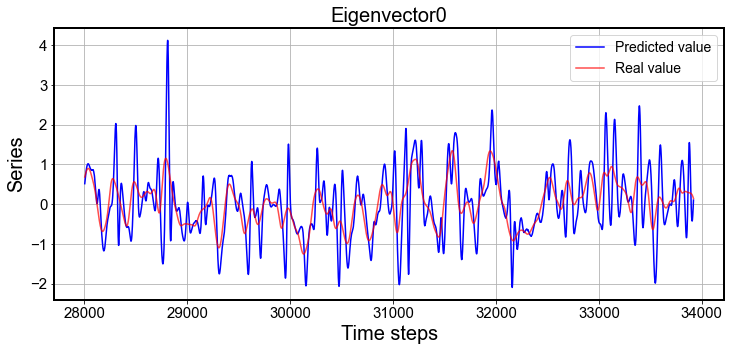

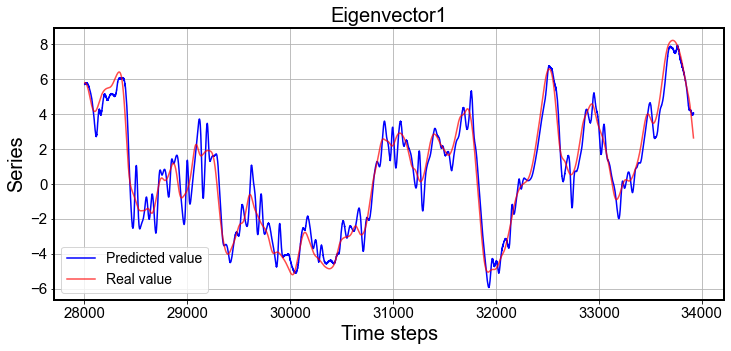

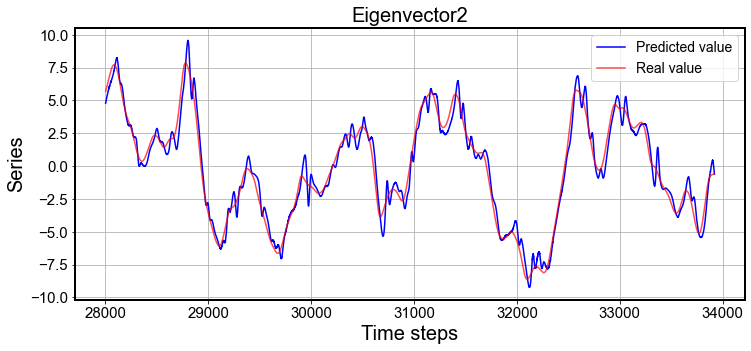

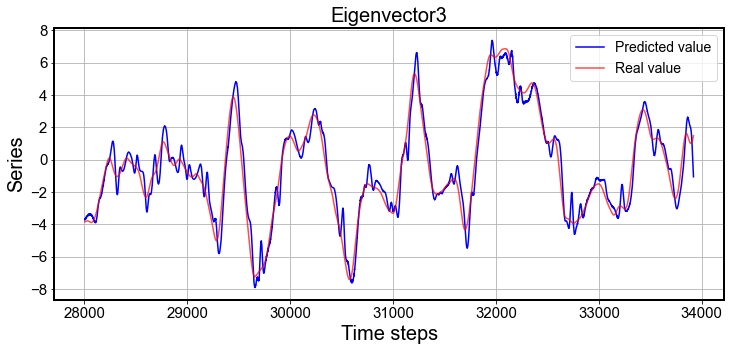

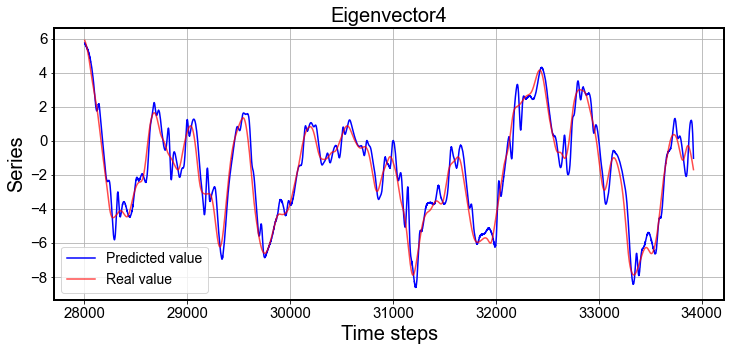

In [61]:
# Plot comparison for test dataset - first eigenvectors

for i in tqdm(range(5)):
    
    l = load_model('trained_models_Kuramoto/' + str(i), verbose=False)
    p = predict_model(l, data=dataframe_test)
    
    dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON) 
    dataframe_train = dataframe[:28000]
    dataframe_test = dataframe[28000:]  
    
    plt.figure(figsize=(12,5))
    
    plt.plot(p['Label'],color='blue',label='Predicted value')
    plt.plot(p[dataframe.columns[-1]],color='red',alpha=0.7,label='Real value')
    
    plt.title('Eigenvector' + str(i))
    plt.xlabel('Time steps')
    plt.ylabel('Series')
    plt.legend()
    #plt.xlim([30000,34000])
    #plt.ylim([-10,9])

100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


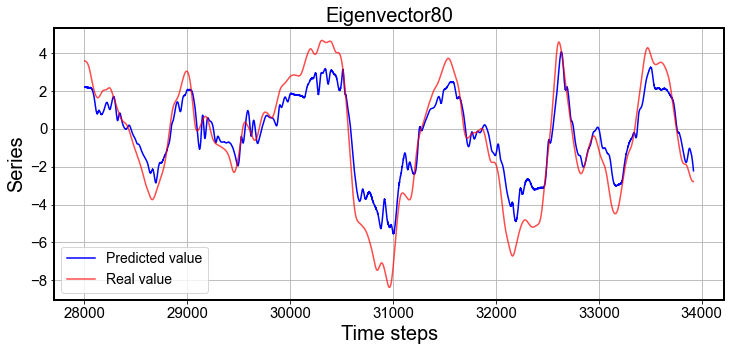

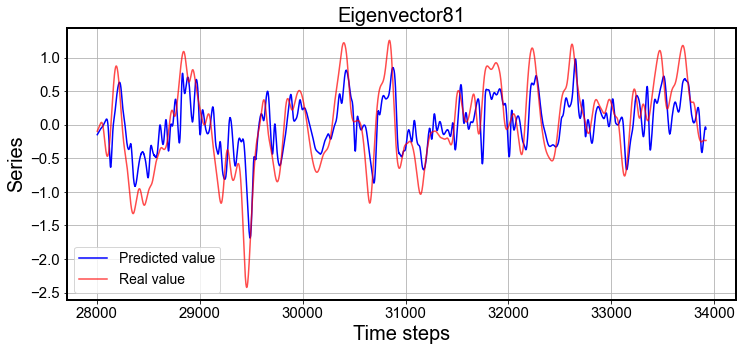

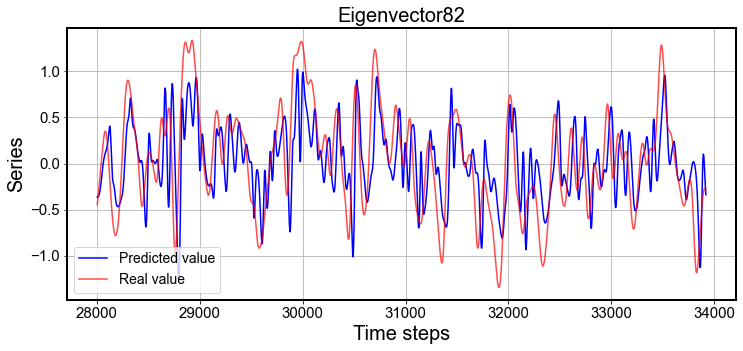

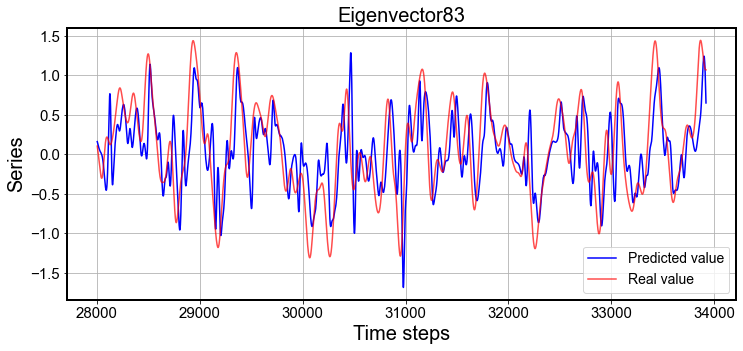

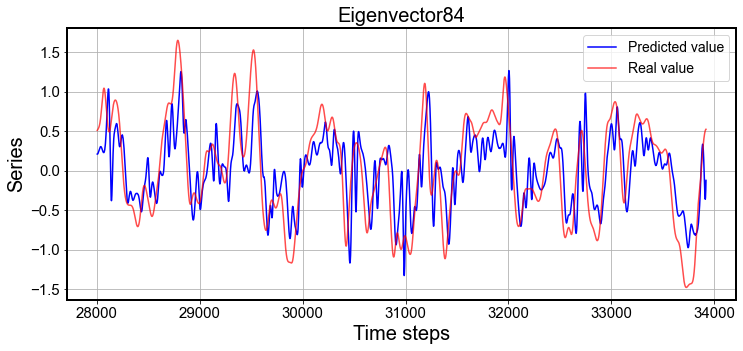

In [62]:
# Plot comparison for test dataset - last few eigenvectors

for i in tqdm(range(5)):
    
    i = i + 80
    l = load_model('trained_models_Kuramoto/' + str(i), verbose=False)
    p = predict_model(l, data=dataframe_test)
    
    dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON) 
    dataframe_train = dataframe[:28000]
    dataframe_test = dataframe[28000:]  
    
    plt.figure(figsize=(12,5))
    
    plt.plot(p['Label'],color='blue',label='Predicted value')
    plt.plot(p[dataframe.columns[-1]],color='red',alpha=0.7,label='Real value')
    
    plt.title('Eigenvector' + str(i))
    plt.xlabel('Time steps')
    plt.ylabel('Series')
    plt.legend()
    #plt.xlim([28000,34000])
    #plt.ylim([-10,9])

In [63]:
predicted_time_series = concat_df.loc[:,concat_df.columns == 'Label']
print(predicted_time_series.shape)
predicted_time_series.columns = ['Eigenvector' + str(i) for i in range(df.shape[1])]
predicted_time_series

(5918, 93)


Eigenvector0  Eigenvector1  Eigenvector2  Eigenvector3  Eigenvector4  \
28003      5.615569      4.723234     -3.849114      5.703487      3.348101   
28004      5.619789      4.783693     -3.832511      5.672237      3.351584   
28005      5.616640      4.792165     -3.833507      5.656612      3.360746   
28006      5.638237      4.857997     -3.797476      5.656612      3.347085   
28007      5.627663      4.885322     -3.808958      5.687862      3.355347   
...             ...           ...           ...           ...           ...   
33916      4.145214     -0.199434     -0.497016     -0.374637     -3.062052   
33917      4.152770     -0.274212     -0.641278     -0.579716     -3.165426   
33918      4.161670     -0.387573     -0.786427     -0.798466     -3.276673   
33919      4.210923     -0.508447     -0.901307     -1.007450     -3.372996   
33920      4.185930     -0.597389     -1.027226     -1.235965     -3.473454   

       Eigenvector5  Eigenvector6  Eigenvector7  Eigenvector8  Eigenvector9  \
28003     -0.880207      3.988623     -5.084749     -2.176451      2.265027   
28004     -0.898948      4.021788     -5.115591     -2.191823      2.238666   
28005     -0.915524      4.044745     -5.133920     -2.205852      2.192778   
28006     -0.930211      4.089697     -5.156733     -2.221531      2.149154   
28007     -0.945711      4.113249     -5.196178     -2.235896      2.130923   
...             ...           ...           ...           ...           ...   
33916     -1.515545      0.803559      7.332631     -0.035427      0.609931   
33917     -1.561124      0.803882      7.214045     -0.019088      0.661910   
33918     -1.608956      0.867887      7.076194     -0.004960      0.716353   
33919     -1.658847      0.903897      6.989141      0.006813      0.770429   
33920     -1.711543      0.921954      6.861484      0.019142      0.824742   

       ...  Eigenvector83  Eigenvector84  Eigenvector85  Eigenvector86  \
28003  ...       0.212361      -0.097854       0.422762       0.034180   
28004  ...       0.212185      -0.100493       0.433092       0.045410   
28005  ...       0.213269      -0.103129       0.442698       0.052246   
28006  ...       0.215001      -0.105270       0.452461       0.057617   
28007  ...       0.215376      -0.108232       0.460158       0.062500   
...    ...            ...            ...            ...            ...   
33916  ...      -0.371524       0.257957       0.756065      -0.438599   
33917  ...      -0.340140       0.264616       0.811739      -0.448120   
33918  ...      -0.297202       0.271535       0.860933      -0.457581   
33919  ...      -0.243329       0.284120       0.905099      -0.467041   
33920  ...      -0.177818       0.298025       0.941975      -0.475830   

       Eigenvector87  Eigenvector88  Eigenvector89  Eigenvector90  \
28003       0.308172       0.383297      -0.351878       0.570801   
28004       0.298406       0.381174      -0.359776       0.570068   
28005       0.293523       0.378571      -0.368921       0.569336   
28006       0.290593       0.375714      -0.377717       0.568115   
28007       0.284734       0.372227      -0.385463       0.565430   
...              ...            ...            ...            ...   
33916      -0.425227      -0.506883      -0.044429      -0.358887   
33917      -0.411555      -0.493030      -0.061245      -0.356934   
33918      -0.388118      -0.473699      -0.080727      -0.353027   
33919      -0.366633      -0.454337      -0.102960      -0.344238   
33920      -0.322688      -0.433762      -0.127923      -0.341309   

       Eigenvector91  Eigenvector92  
28003       0.150879       0.084839  
28004       0.149658       0.096069  
28005       0.147949       0.108276  
28006       0.147217       0.120117  
28007       0.145996       0.131714  
...              ...            ...  
33916      -0.009033       0.043701  
33917      -0.060059       0.060791  
33918      -0.113525       0.077393  
33919      

# Visualizing the Kuramoto equation from model prediction

In [64]:
y_test_forecast = pca.model_red.inverse_transform(predicted_time_series) # Returning the 93 time series back into the problem series
y_test_forecast = pd.DataFrame(y_test_forecast) 

In [65]:
predicted_time_series.describe()

Eigenvector0  Eigenvector1  Eigenvector2  Eigenvector3  Eigenvector4  \
count   5918.000000   5918.000000   5918.000000   5918.000000   5918.000000   
mean       0.568670     -0.170968     -0.529780     -1.618286     -0.390514   
std        3.275802      3.775002      3.097597      2.850200      3.049212   
min       -5.816489     -9.081434     -8.070847     -8.530888     -8.416331   
25%       -2.276176     -2.985191     -2.562567     -3.624637     -2.374208   
50%        0.723394     -0.030626     -0.819412     -1.409305     -0.193573   
75%        2.961727      2.561212      1.323667      0.435909      2.155619   
max        7.940167      9.504458      7.447845      5.703487      6.221123   

       Eigenvector5  Eigenvector6  Eigenvector7  Eigenvector8  Eigenvector9  \
count   5918.000000   5918.000000   5918.000000   5918.000000   5918.000000   
mean      -0.495543     -0.291510     -0.158042     -0.273481     -0.288570   
std        2.899528      2.806075      3.084653      2.583495      2.681932   
min       -6.493441     -7.016100     -7.351884     -6.647795     -6.942342   
25%       -2.651791     -2.433023     -2.440233     -2.417234     -2.250598   
50%       -0.715071     -0.247436     -0.189714     -0.206520     -0.285562   
75%        1.279009      1.632245      2.075463      1.774879      1.731124   
max        6.456732      5.754357      8.197909      4.944414      8.261336   

       ...  Eigenvector83  Eigenvector84  Eigenvector85  Eigenvector86  \
count  ...    5918.000000    5918.000000    5918.000000    5918.000000   
mean   ...       0.011324      -0.022255       0.052816       0.011718   
std    ...       0.455705       0.394359       0.388613       0.432491   
min    ...      -1.395902      -1.235968      -1.166665      -1.954102   
25%    ...      -0.318981      -0.281203      -0.212045      -0.283691   
50%    ...       0.061820      -0.025323       0.071535      -0.018799   
75%    ...       0.321366       0.235165       0.326882       0.239681   
max    ...       1.343559       1.228101       1.053696       1.819824   

       Eigenvector87  Eigenvector88  Eigenvector89  Eigenvector90  \
count    5918.000000    5918.000000    5918.000000    5918.000000   
mean        0.027173       0.030555       0.044343       0.076760   
std         0.396484       0.361492       0.407795       0.337065   
min        -1.440364      -1.009327      -1.522479      -0.959473   
25%        -0.254817      -0.183975      -0.235565      -0.169922   
50%         0.027410       0.054786       0.025984       0.093750   
75%         0.308172       0.277655       0.307512       0.319916   
max         1.508367       1.062298       1.368623       1.036377   

       Eigenvector91  Eigenvector92  
count    5918.000000    5918.000000  
mean        0.013981       0.007219  
std         0.318232       0.344061  
min        -0.929871      -0.863281  
25%        -0.214813      -0.248535  
50%         0.025925       0.011017  
75%         0.228882       0.220444  
max         0.841309       1.230469  

[8 rows x 93 columns]

In [66]:
yhat = scaler2.inverse_transform(y_test_forecast)

yhat = pd.DataFrame(yhat)
yhat.index = pd.DataFrame(predicted_time_series).index
yhat

0         1         2         3         4         5         6    \
28003 -0.618063 -1.325244 -1.413404 -1.201201 -0.851851 -0.250947  0.732557   
28004 -0.584703 -1.306398 -1.411187 -1.209642 -0.866696 -0.274917  0.695395   
28005 -0.580221 -1.307860 -1.418118 -1.216410 -0.871016 -0.283400  0.673565   
28006 -0.551510 -1.288995 -1.412785 -1.220711 -0.882877 -0.306796  0.635133   
28007 -0.547605 -1.293422 -1.422769 -1.227237 -0.882039 -0.306223  0.623359   
...         ...       ...       ...       ...       ...       ...       ...   
33916 -0.772019 -1.037572 -0.753135  0.045015  0.991313  1.524878  1.243584   
33917 -0.762063 -1.017261 -0.730778  0.065355  1.011305  1.536465  1.229038   
33918 -0.761891 -1.004923 -0.716252  0.076440  1.022569  1.545204  1.221033   
33919 -0.769503 -0.996568 -0.701263  0.092288  1.042378  1.564540  1.223089   
33920 -0.755652 -0.966314 -0.670156  0.114879  1.057631  1.568810  1.203445   

            7         8         9    ...       246       247       248  \
28003  1.970763  2.931537  2.921041  ... -0.192855  0.319954  0.267841   
28004  1.928188  2.906931  2.936538  ... -0.195507  0.319909  0.268517   
28005  1.895914  2.883969  2.945031  ... -0.200124  0.316321  0.265248   
28006  1.851843  2.858442  2.959702  ... -0.199259  0.325924  0.277885   
28007  1.826916  2.837537  2.965214  ... -0.207735  0.319902  0.275332   
...         ...       ...       ...  ...       ...       ...       ...   
33916  0.244091 -0.992012 -1.812038  ...  0.603509 -0.838017 -1.595955   
33917  0.202863 -1.036465 -1.834651  ...  0.568565 -0.874260 -1.636456   
33918  0.173992 -1.070928 -1.855434  ...  0.515899 -0.929525 -1.696063   
33919  0.152825 -1.099963 -1.873155  ...  0.465543 -0.978596 -1.753218   
33920  0.109573 -1.144912 -1.896751  ...  0.441464 -0.998219 -1.793058   

            249       250       251       252       253       254       255  
28003 -0.081714 -0.150437  0.485788  1.541059  2.180900  1.823085  0.644537  
28004 -0.085794 -0.164648  0.460865  1.514721  2.169249  1.836546  0.677232  
28005 -0.087973 -0.165392  0.457869  1.505828  2.158145  1.831511  0.680458  
28006 -0.081470 -0.172976  0.433959  1.474176  2.136084  1.832991  0.703686  
28007 -0.080033 -0.169486  0.433604  1.466186  2.125489  1.829157  0.708174  
...         ...       ...       ...       ...       ...       ...       ...  
33916 -1.635938 -1.244405 -0.686520 -0.130920  0.228636  0.197178 -0.230437  
33917 -1.657095 -1.226503 -0.644686 -0.100880  0.232496  0.188433 -0.233727  
33918 -1.693041 -1.212837 -0.595267 -0.058795  0.242690  0.176156 -0.246570  
33919 -1.729453 -1.195985 -0.536456 -0.006676  0.256490  0.159508 -0.267994  
33920 -1.768243 -1.197704 -0.502765  0.022534  0.255759  0.141359 -0.276800  

[5918 rows x 256 columns]

In [67]:
yhat.describe()

0            1            2            3            4    \
count  5918.000000  5918.000000  5918.000000  5918.000000  5918.000000   
mean     -0.086167    -0.151583    -0.072704     0.075161     0.214630   
std       1.182544     1.196571     1.182791     1.203136     1.250791   
min      -2.875184    -3.874851    -3.438581    -3.759296    -3.037932   
25%      -1.004147    -1.094152    -0.995429    -0.754713    -0.759806   
50%      -0.077033    -0.179013    -0.098505     0.032031     0.202815   
75%       0.756655     0.627511     0.701497     1.013028     1.201852   
max       3.141313     2.894964     3.571571     4.393164     4.462690   

               5            6            7            8            9    ...  \
count  5918.000000  5918.000000  5918.000000  5918.000000  5918.000000  ...   
mean      0.278604     0.228925     0.089744    -0.065480    -0.159454  ...   
std       1.224783     1.154905     1.178105     1.250361     1.271130  ...   
min      -3.093251    -2.587198    -3.913615    -3.206054    -3.084355  ...   
25%      -0.576434    -0.451034    -0.889499    -1.157473    -1.182488  ...   
50%       0.370011     0.358095     0.185214    -0.056535    -0.222742  ...   
75%       1.139251     1.028464     0.950336     0.823571     0.611380  ...   
max       4.450654     4.730304     4.339591     3.352117     3.232025  ...   

               246          247          248          249          250  \
count  5918.000000  5918.000000  5918.000000  5918.000000  5918.000000   
mean     -0.382536    -0.702851    -0.754937    -0.558151    -0.210153   
std       1.083208     0.964030     0.919683     0.991322     1.036498   
min      -4.774413    -3.707898    -3.874876    -5.238011    -4.505828   
25%      -1.159156    -1.544446    -1.478730    -1.264393    -1.041718   
50%      -0.443397    -0.786554    -0.908271    -0.705034    -0.274222   
75%       0.300444     0.017538    -0.084939     0.104128     0.519044   
max       3.283861     2.031002     2.328964     2.351917     2.028573   

               251          252          253          254          255  
count  5918.000000  5918.000000  5918.000000  5918.000000  5918.000000  
mean      0.157738     0.422809     0.502545     0.378112     0.128582  
std       0.991352     0.981712     1.065002     1.114835     1.138136  
min      -3.178240    -3.245235    -2.980751    -2.764334    -2.782139  
25%      -0.489994    -0.212406    -0.191043    -0.297216    -0.530465  
50%       0.143726     0.463150     0.500454     0.435458     0.165597  
75%       0.942586     1.143933     1.283236     1.201461     0.918931  
max       2.165971     3.062322     4.114116     3.368093     3.172328  

[8 rows x 256 columns]

In [68]:
X_test2 = X[-yhat.shape[0]:]
T_test2 = T[-yhat.shape[0]:]
U_test2 = U[-yhat.shape[0]:]

U_test_reduced2 = U_test_reduced_inverse[-yhat.shape[0]:]

Mean absolute error (MAE) for forecasting: 0.3425760873837558


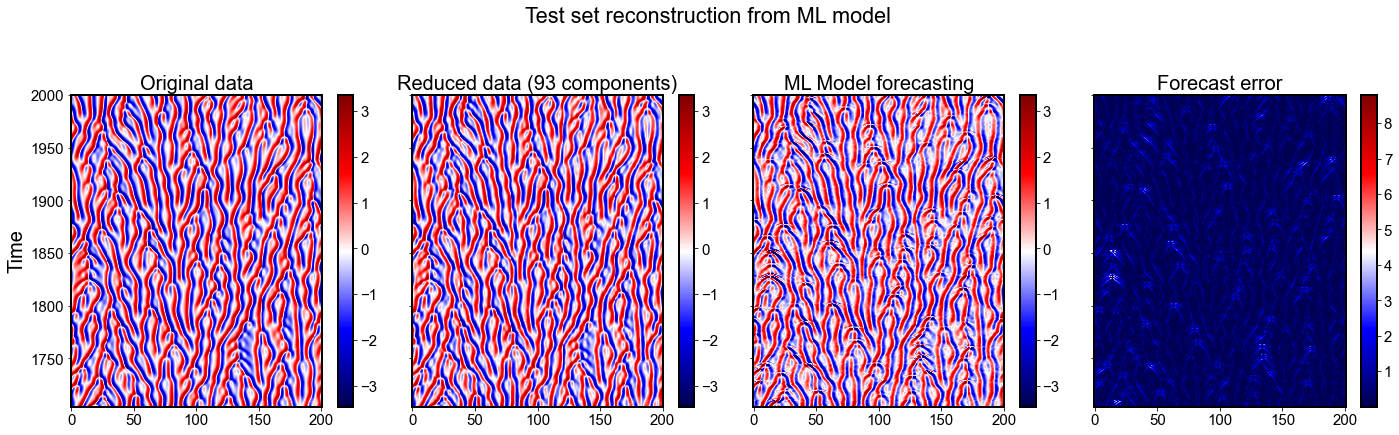

In [69]:
d=93
fig, ax = plt.subplots(1,4,sharey=True,figsize=(20, 6))
plt.suptitle('Test set reconstruction from ML model', y=1.02)

vmin = U_test2.min().min()
vmax = U_test2.max().max()

surf1 = ax[0].pcolor(X_test2, T_test2, U_test2, cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin, vmax=vmax)
ax[0].set_title('Original data')
ax[0].set_ylabel('Time')

surf2 = ax[1].pcolor(X_test2, T_test2, U_test_reduced2,cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin, vmax=vmax)
ax[1].set_title('Reduced data ({} components)'.format(d))

surf3 = ax[2].pcolor(X_test2, T_test2, yhat,cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin, vmax=vmax)
ax[2].set_title('ML Model forecasting')

diff = abs(yhat-U_test2)
surf4 = ax[3].pcolor(X_test2,  T_test2, diff,cmap=plt.get_cmap("seismic"),shading='auto')
ax[3].set_title('Forecast error')

plt.colorbar(surf1, ax=ax[0])
plt.colorbar(surf2, ax=ax[1])
plt.colorbar(surf3, ax=ax[2])
plt.colorbar(surf4, ax=ax[3])

plt.tight_layout()
print('Mean absolute error (MAE) for forecasting: {}'.format(np.mean(diff.mean())))

Wow! Looks like the bad performance for the last eigenvectors really affected the model. The outliers of the dataset was responsible for the larger scale for the forecasting model

- Test set error from reduced components (using 93 instead of 256): 0.1808
- Test set error from model prediction:  0.34257

Let us decrease the forecasting horizon from 80 to 40 and see how it improves

# Correcting large MAE due to forecasting horizon

In [71]:
NLAGS = NLAGS 
HORIZON = 40 

all_results = [] # Save the MAE result for each HORIZON value to determine how far we can forecast
final_model = {}
train_all_time_series(df,nlags=NLAGS,HORIZON=HORIZON)

# Display the best model selected for each time series.

concat_results = pd.concat(all_results,axis=0)
concat_results.head(10)

MAE     MSE    RMSE      R2   RMSLE    MAPE time_series
0  0.0952  0.0147  0.1213  0.9982  0.0497  0.2760           0
0  0.0767  0.0089  0.0946  0.9992  0.0358  0.1048           1
0  0.0823  0.0118  0.1088  0.9985  0.0499  0.1801           2
0  0.0834  0.0126  0.1122  0.9988  0.0501  0.3014           3
0  0.0927  0.0163  0.1275  0.9981  0.0571  0.6926           4
0  0.0868  0.0125  0.1116  0.9982  0.0509  0.2146           5
0  0.0881  0.0127  0.1128  0.9991  0.0431  0.1205           6
0  0.0926  0.0134  0.1156  0.9988  0.0527  0.2373           7
0  0.0973  0.0157  0.1253  0.9985  0.0488  0.4191           8
0  0.0869  0.0137  0.1170  0.9976  0.0556  0.2586           9

In [72]:
concat_results.tail(10)

MAE     MSE    RMSE      R2   RMSLE    MAPE time_series
0  0.0763  0.0097  0.0983  0.9702  0.0687  1.0392          83
0  0.0687  0.0081  0.0898  0.9653  0.0634  1.1703          84
0  0.0699  0.0085  0.0920  0.9602  0.0638  1.1860          85
0  0.0732  0.0084  0.0918  0.9769  0.0636  1.4434          86
0  0.0625  0.0068  0.0827  0.9679  0.0580  1.3896          87
0  0.0679  0.0075  0.0864  0.9689  0.0610  1.0302          88
0  0.0605  0.0060  0.0772  0.9710  0.0566  3.1075          89
0  0.0653  0.0067  0.0818  0.9750  0.0574  0.8079          90
0  0.0747  0.0090  0.0949  0.9654  0.0661  1.8664          91
0  0.0700  0.0077  0.0877  0.9657  0.0617  0.8289          92

In [73]:
all_score_df = []

for i in tqdm(range(df.shape[1])):
    l = load_model('trained_models_Kuramoto/' + str(i), verbose=False)
    
    dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON) 
    dataframe_train = dataframe[:28000]
    dataframe_test = dataframe[28000:]        
    
    p = predict_model(l, data=dataframe_test)
    all_score_df.append(p)

concat_df = pd.concat(all_score_df, axis=1)

100%|██████████| 93/93 [01:25<00:00,  1.09it/s]


Text(0.5, 1.0, 'Forecasting R^2 for each time series - Horizon=40')

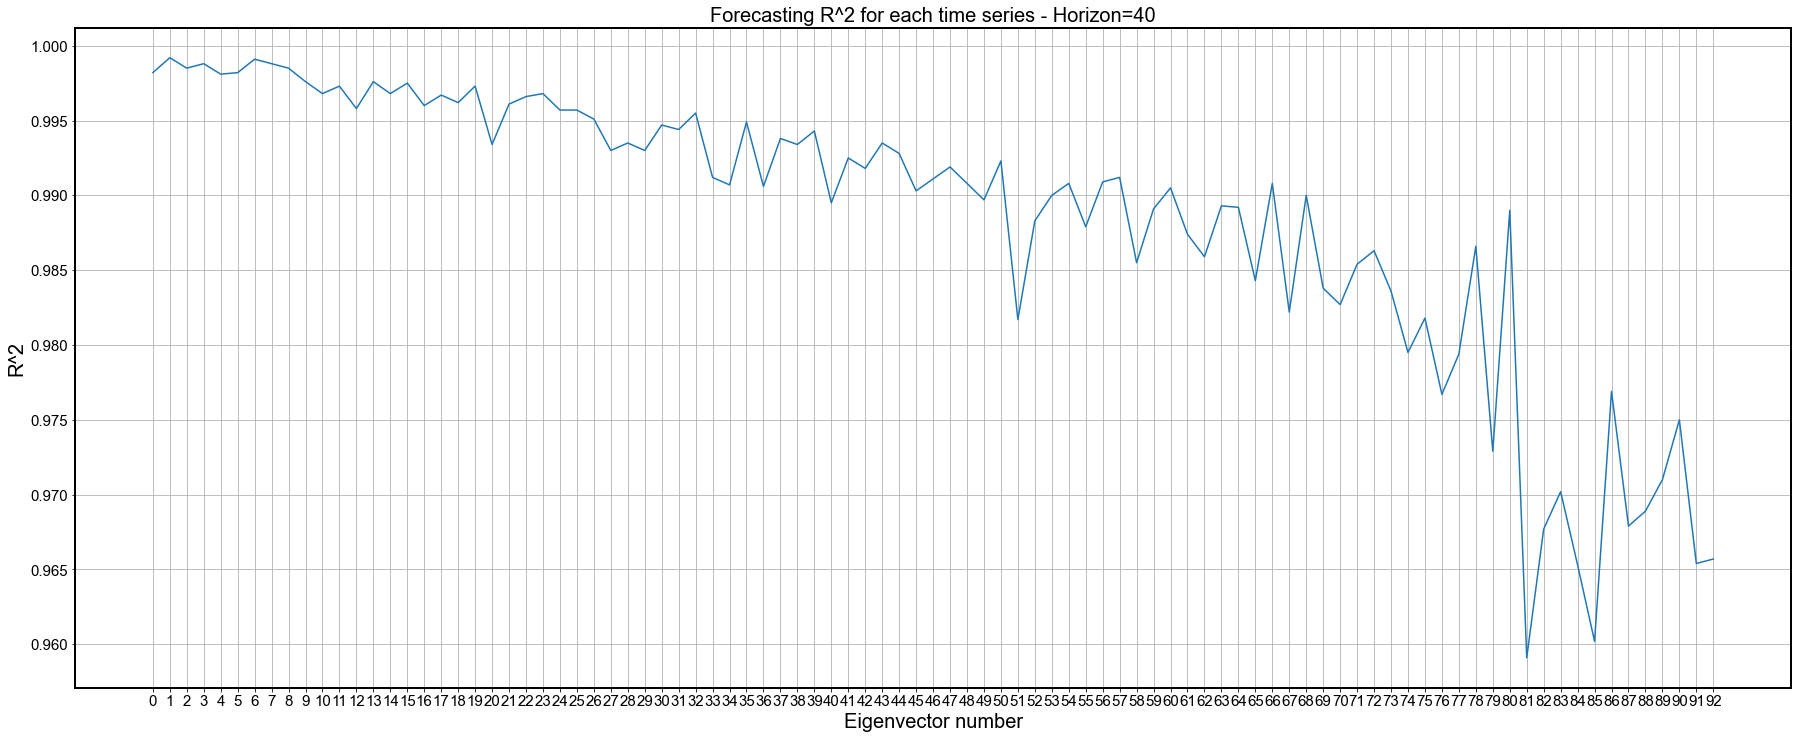

In [74]:
plt.plot(concat_results['time_series'],concat_results['R2'])  
plt.tight_layout()
plt.ylabel('R^2')
plt.xlabel('Eigenvector number')
plt.title('Forecasting R^2 for each time series - Horizon=40')

In [75]:
predicted_time_series = concat_df.loc[:,concat_df.columns == 'Label']
predicted_time_series.columns = ['Eigenvector' + str(i) for i in range(df.shape[1])]

y_test_forecast = pca.model_red.inverse_transform(predicted_time_series) 
y_test_forecast = pd.DataFrame(y_test_forecast) 
yhat = pd.DataFrame(scaler2.inverse_transform(y_test_forecast))

X_test2 = X[-yhat.shape[0]:]
T_test2 = T[-yhat.shape[0]:]
U_test2 = U[-yhat.shape[0]:]
U_test_reduced2 = U_test_reduced_inverse[-yhat.shape[0]:]

'Mean absolute error (MAE) for forecasting: 0.12786767783222563'

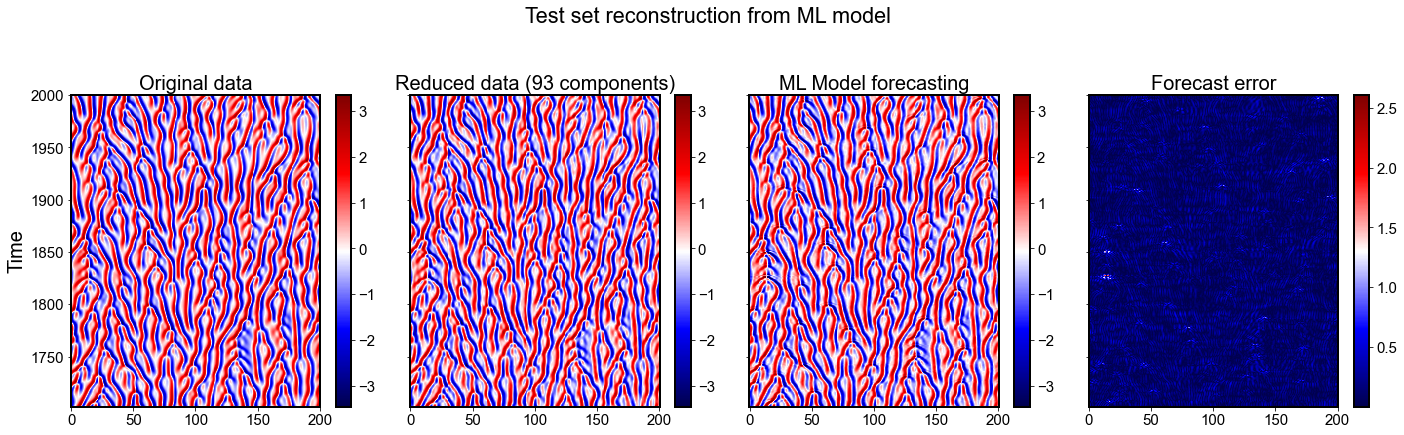

In [76]:
fig, ax = plt.subplots(1,4,sharey=True,figsize=(20, 6))
plt.suptitle('Test set reconstruction from ML model', y=1.02)

vmin = U_test2.min().min()
vmax = U_test2.max().max()

surf1 = ax[0].pcolor(X_test2, T_test2, U_test2, cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin, vmax=vmax)
ax[0].set_title('Original data')
ax[0].set_ylabel('Time')

surf2 = ax[1].pcolor(X_test2, T_test2, U_test_reduced2,cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin, vmax=vmax)
ax[1].set_title('Reduced data ({} components)'.format(d))

surf3 = ax[2].pcolor(X_test2, T_test2, yhat,cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin, vmax=vmax)
ax[2].set_title('ML Model forecasting')

diff = abs(yhat-U_test2)
surf4 = ax[3].pcolor(X_test2,  T_test2, diff,cmap=plt.get_cmap("seismic"),shading='auto')
ax[3].set_title('Forecast error')

plt.colorbar(surf1, ax=ax[0])
plt.colorbar(surf2, ax=ax[1])
plt.colorbar(surf3, ax=ax[2])
plt.colorbar(surf4, ax=ax[3])

plt.tight_layout()

('Mean absolute error (MAE) for forecasting: {}'.format(np.mean(diff.mean())))

In [77]:
('Mean absolute error (MAE) for forecasting: {}'.format(np.mean(diff.mean())))

'Mean absolute error (MAE) for forecasting: 0.12786767783222563'

Yep. Looks like the forecasting horizon was the issue

- Test set error from reduced components (using 93 instead of 256): 0.18097
- Test set error from model forecasting - 80 time steps: 0.34257
- Test set error from model forecasting - 40 time steps: 0.12786

# Conclusions:

- Defining time series forecasting as a **supervised** learning problem is very complicated in this case due the extensive feature engineering (create lag features) and difficulty in training various models. 

- Deep learning techniques would automatically learn the feature mapping between input and output. Even more, we would not have to create a model for each individual time series. This should lead to a more elegant solution and hopefully the MAE continues to be low.

- Statistical models such as ARIMA might provide similiar results without us having to worry about the lag terms since a grid search involving this function will provide us these optimal hyperparameters. These models also deal with non stationarity automatically in their formulation. The trouble of forecasting all individual time series would remain however (I believe). This should be tested later on as well. 

- The model can forecast 40 time steps (17.5) seconds into the future with good accuracy (comparable to the PCA test set error). When we get to around 80 time steps, the model performance is not good enough due to the bad performance of the last eigenvectors.

- The oscilations in the predicted model are due to the selected linear models and their difficulty in capturing the oscilations of the last eigenvectors.